# Initialising

## Importing modules

In [17]:
%matplotlib notebook

import datetime
import numpy as np
import matplotlib as mpl
import re
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.signal import savgol_filter

import qcodes as qc
from qcodes.dataset.data_set import load_by_id
from qcodes.dataset.database import initialise_database

#from data_analysis.tools import smooth

In [3]:
from qcodes import new_experiment, Station, Instrument

In [4]:
station = Station()

In [6]:
station.snapshot()

{'components': {},
 'default_measurement': [],
 'instruments': {},
 'parameters': {}}

In [18]:
qc.config["core"]["db_location"] = datetime.date.today().strftime(r'D:\OneDrive\BF3\Data\experiments_2019-06-12.db')
# automatically uses a different DB file for each month
initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists

In [19]:
d=load_by_id(7)

In [20]:
d.get_parameters()

[ParamSpec('mdac_CUT_voltage', 'numeric', 'mdac_CUT_voltage', 'V', inferred_from=[], depends_on=[]),
 ParamSpec('lockin1_dc', 'numeric', 'lockin1_dc', 'V', inferred_from=[], depends_on=[]),
 ParamSpec('current1', 'numeric', 'current1', 'A', inferred_from=[], depends_on=['mdac_CUT_voltage', 'lockin1_dc']),
 ParamSpec('raw_voltage_dc1', 'numeric', 'raw_voltage_dc1', 'V', inferred_from=[], depends_on=['mdac_CUT_voltage', 'lockin1_dc']),
 ParamSpec('conductance1', 'numeric', 'conductance1', '2e^2/h', inferred_from=[], depends_on=['mdac_CUT_voltage', 'lockin1_dc']),
 ParamSpec('Lockin1_X', 'numeric', 'Lockin1_X', 'V', inferred_from=[], depends_on=['mdac_CUT_voltage', 'lockin1_dc']),
 ParamSpec('Lockin1_Y', 'numeric', 'Lockin1_Y', 'V', inferred_from=[], depends_on=['mdac_CUT_voltage', 'lockin1_dc']),
 ParamSpec('Lockin1_R', 'numeric', 'Lockin1_R', 'V', inferred_from=[], depends_on=['mdac_CUT_voltage', 'lockin1_dc']),
 ParamSpec('Lockin1_phase', 'numeric', 'Lockin1_phase', 'deg', inferred_fro

In [21]:
gate = d.get_values('mdac_CUT_voltage')
bias = d.get_values('lockin1_dc')
g = d.get_values('conductance1')

In [40]:
x, y, z = unpack_2D_sweep(gate, bias, g)

<IPython.core.display.Javascript object>


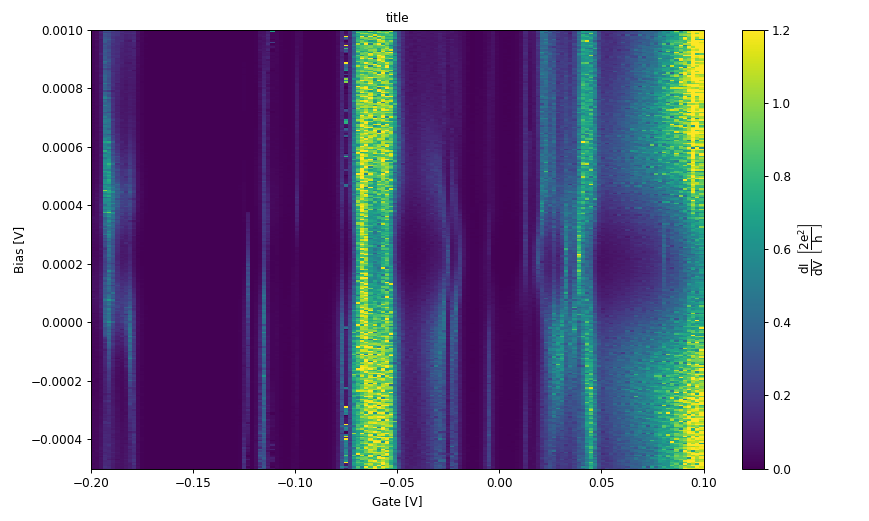

(<matplotlib.figure.Figure at 0x2598e4c48d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x25989866978>)

In [50]:
colorplot(x, y, z, vmin=0, vmax=1.2, figsize=(10,6))

## Constants

In [31]:
m = 9.11e-31
h = 6.623e-34
hbar = h/(2*np.pi)
e = 1.60217662e-19
G0 = 2*e**2/h
Phi0 = h/e

## Global variables

In [32]:
#where_db_files_are = r'C:/Users/Alberto/Desktop/Q0243/Data/' # change this path accordingly to the PC you are using
where_I_save_plots = r'Albertos_plots/' # relative path from current directory
g_label = '$\\dfrac{{\\mathrm{dI}}}{{\\mathrm{dV}}}$' + ' ' + '$\\left[\\dfrac{{2\\mathrm{e}^2}}{{\\mathrm{h}}}\\right]$'

# Function definitions

In [49]:
def unpack_2D_sweep(slow_sweep, fast_sweep, z):
    slow_sweep = np.array(slow_sweep)
    fast_sweep = np.array(fast_sweep)
    z = np.array(z)
    x = np.unique(slow_sweep.round(decimals=12))
    if x[0] > x[-1]:
        x = x[::-1]
    y = np.unique(fast_sweep.round(decimals=12))
    if y[0] > y[-1]:
        y = y[::-1]
    zz = np.reshape(z, (len(x), len(y)))
    return x, y, zz

def unpack_back_and_forth(x, y_forth_and_back, z):
    x = np.array(x)
    y_forth_and_back = np.array(y_forth_and_back)
    z = np.array(z)
    x_slow_sweep=True
    if x[0]!=x[1]:
        x_slow_sweep=False
    x = np.unique(x.round(decimals=12))
    if x[0] > x[-1]:
        x = x[::-1]
    y_forth = np.unique(y_forth_and_back.round(decimals=12))
    y_back = y_forth[::-1]
    if x_slow_sweep==True:
        zz = np.reshape(z, (len(x), len(y_forth) + len(y_back)))
        z_forth = zz[:, 0:len(y_forth)]
        z_back = zz[:, len(y_forth):len(y_forth)+len(y_back)]
    else:
        z_forth = z[:len(x)*len(y_forth)]
        z_back = z[len(x)*len(y_forth):len(x)*(len(y_forth)+len(y_back))]
        z_forth = np.reshape(z_forth, (len(y_forth), len(x))).T
        z_back = np.reshape(z_back, (len(y_back), len(x))).T
    return x, y_forth, y_back, z_forth, z_back

def unpack_back_and_forth_back_and_forth(slow_sweep_forth_and_back, fast_sweep_forth_and_back, z):
    slow_sweep_forth_and_back = np.array(slow_sweep_forth_and_back)
    fast_sweep_forth_and_back = np.array(fast_sweep_forth_and_back)
    z = np.array(z)
    x = np.unique(slow_sweep_forth_and_back.round(decimals=12))
    y = np.unique(fast_sweep_forth_and_back.round(decimals=12))
    zz = np.reshape(z, (2*len(x), 2*len(y)))
    z_forth_forth = zz[0:len(x), 0:len(y)]
    z_forth_back = zz[0:len(x), len(y):2*len(y)]
    z_back_forth = zz[len(x):2*len(x), 0:len(y)]
    z_back_back = zz[len(x):2*len(x), len(y):2*len(y)]
    return x, y, z_forth_forth, z_forth_back, z_back_forth, z_back_back

def colorplot_Backward(x, y, z, cut=-10):
    params = {'legend.fontsize': 'medium',
              'figure.figsize': (5.5, 4),
              'axes.labelsize': 'medium',
              'axes.titlesize':'medium',
              'xtick.labelsize':'medium',
              'ytick.labelsize':'medium'}
    mpl.rcParams.update(params)
    
    m = np.max(z[:, 0])
    vmax = 1.05*m
    
    cmap = plt.cm.viridis #viridis it's the default
    norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
    
    fig, axes = plt.subplots(ncols=1, nrows=1, sharey=True, constrained_layout=True)
    cmap = plt.cm.viridis #viridis it's the default
    norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
    yy = y[::-1]
    im = axes.pcolor(x, yy[yy>=cut], z.T[yy>=cut,:], cmap=cmap, norm=norm)
    axes.set(xlabel='$B_x$ [T]', ylabel='Gate [V]', title='backward gate sweep')
    
    cbar = fig.colorbar(im, ax=axes)
    cbar.ax.set_ylabel(g_label)
    
    return fig, axes

def colorplot(x, y, z, vmin=0, vmax=1, title='title', xlabel='Gate [V]', ylabel='Bias [V]', figsize=(8,6)):
    params = {'legend.fontsize': 'medium',
              'figure.figsize': figsize,
              'axes.labelsize': 'medium',
              'axes.titlesize':'medium',
              'xtick.labelsize':'medium',
              'ytick.labelsize':'medium'}
    mpl.rcParams.update(params)
    
    fig, axes = plt.subplots(ncols=1, nrows=1, sharey=True)
    fig.set_tight_layout(True)
    cmap = plt.cm.viridis #viridis it's the default
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    im = axes.pcolor(x, y, z.T, cmap=cmap, norm=norm)
    axes.set(xlabel=xlabel, ylabel=ylabel, title=title)
    
    cbar = fig.colorbar(im, ax=axes)
    cbar.ax.set_ylabel(g_label)
    
    return fig, axes
 
def colorplot_Forward(x, y, z, cut=-10):
    params = {'legend.fontsize': 'medium',
              'figure.figsize': (5.5, 4),
              'axes.labelsize': 'medium',
              'axes.titlesize':'medium',
              'xtick.labelsize':'medium',
              'ytick.labelsize':'medium'}
    mpl.rcParams.update(params)
    
    m = np.max(z[:, -1])
    vmax = 1.05*m
    
    cmap = plt.cm.viridis #viridis it's the default
    norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
    
    fig, axes = plt.subplots(ncols=1, nrows=1, sharey=True)
    cmap = plt.cm.viridis #viridis it's the default
    norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
    im = axes.pcolor(x, y[y>=cut], z.T[y>=cut,:], cmap=cmap, norm=norm)
    axes.set(xlabel='$B_x$ [T]', ylabel='Gate [V]', title='forward gate sweep')
    
    cbar = fig.colorbar(im, ax=axes)
    cbar.ax.set_ylabel(g_label)
    
    return fig, axes
    
def colorplot_ForwardBackward(x, y, zs, vmax=0, xscale=1, forward_cut=-10, backward_cut=-10, 
                              xlabel='$B_x$ [T]', ylabel='Gate [V]', 
                              barlabel=g_label, 
                              forward_backward_sweep='gate'):
    params = {'legend.fontsize': 'medium',
              'figure.figsize': (8, 4),
              'axes.labelsize': 'medium',
              'axes.titlesize':'medium',
              'xtick.labelsize':'medium',
              'ytick.labelsize':'medium'}
    mpl.rcParams.update(params)
    
    if vmax==0:
        m = max(np.max(zs[0][:, -1]), np.max(zs[1][:, 0]))
        vmax = 1.05*m
    
    cmap = plt.cm.viridis #viridis it's the default
    norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
    
    fig, axes = plt.subplots(ncols=2, nrows=1, sharey=True, constrained_layout=True)
    cmap = plt.cm.viridis #viridis it's the default
    norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
    ys = (y, y[::-1])
    directions = ('forward', 'backward')
    axes[0].set(ylabel=ylabel)
    cuts = (forward_cut, backward_cut)
    for i, ax in enumerate(axes.flat):
        im = ax.pcolor(x*xscale, ys[i][ys[i]>=cuts[i]], zs[i][:,ys[i]>=cuts[i]].T, cmap=cmap, norm=norm)
        ax.set(xlabel=xlabel, title='{} {} sweep'.format(directions[i], forward_backward_sweep))
    
    cbar = fig.colorbar(im, ax=axes.flat)
    cbar.ax.set_ylabel(barlabel)
    
    return fig, axes

def colorplot_phase_ForwardBackward(x, y, zs, degrange=180, xscale=1, xlabel='$B_x$ [T]', ylabel='Gate [V]', 
                              barlabel='deg', 
                              forward_backward_sweep='gate'):
    params = {'legend.fontsize': 'medium',
              'figure.figsize': (8, 4),
              'axes.labelsize': 'medium',
              'axes.titlesize':'medium',
              'xtick.labelsize':'medium',
              'ytick.labelsize':'medium'}
    mpl.rcParams.update(params)
    
    cmap = plt.cm.RdBu #viridis it's the default
    norm = mpl.colors.Normalize(vmin=-degrange, vmax=+degrange)
    
    fig, axes = plt.subplots(ncols=2, nrows=1, sharey=True, constrained_layout=True)
    ys = (y, y[::-1])
    directions = ('forward', 'backward')
    axes[0].set(ylabel=ylabel)
    for i, ax in enumerate(axes.flat):
        im = ax.pcolor(x*xscale, ys[i], zs[i].T, cmap=cmap, norm=norm)
        ax.set(xlabel=xlabel, title='{} {} sweep'.format(directions[i], forward_backward_sweep))
    
    cbar = fig.colorbar(im, ax=axes.flat)
    cbar.ax.set_ylabel(barlabel)
    
    return fig, axes

def brute_meaningless_gate_average(x, y, z, cut=-10):
    a = np.average(z[:, y>=cut], axis=1)
    return a

def hall_mobility(Bx, Rxx, Rxy, Lxx, w, plot=False):
    average_Rxx = np.average(Rxx)
    nte_inverse, intercept, nte_fit_rval, p_value, nte_fit_std_err = stats.linregress(Bx, Rxy)
    mu = np.abs(Lxx * nte_inverse / average_Rxx / w)
    dmu = Lxx * nte_fit_std_err / average_Rxx / w
    round_mu = np.round(mu, decimals=1)
    if plot==True:
        plt.figure('1')
        plt.scatter(Bx, Rxy, s=0.1)
        plt.scatter(Bx, Rxx, s=0.1)
        plt.plot(Bx, intercept + nte_inverse*Bx, linewidth=2, label=r'R_xy: 1/nte = {}, $\mu =${} $cm^2 / (V*s)$'.format(int(nte_inverse), int(round_mu*1e4)))
        plt.plot(Bx, average_Rxx*np.ones(len(Bx)), '--', linewidth=2, label='R_xx: it\'s just the average (it\'s not a fit)')
        plt.legend()
        plt.ylabel('resistance [$\Omega$]')
        plt.xlabel('B_x [T]')
    return mu, dmu

def hall_bar_mobilities(Bx, Rxx, Rxy, Lxx, w):
    mus = []
    dmus = []
    for i in range(len(Rxx[0,:])):
        mu, dmu = hall_mobility(Bx, Rxx[:,i], Rxy[:,i], Lxx, w)
        mus.append(mu)
        dmus.append(dmu)
    return np.array(mus), np.array(dmus)

def pretty_path(experiment_date):
    return '\OneDrive\BF3\Data\experiments_' + experiment_date + '.db'

def path(where_db_files_are, experiment_date):
    return r'C:/Users/Alberto/Desktop/Q0243/Data/experiments_' + experiment_date + '.db'  

def device_source_drain_if_sample_name_is_SAMPLE_SOURCEDRAIN(sample_name):
    try:
        device = re.search('(.+?)_', sample_name).group(1)
        source_letter = re.search('_(.+?)', sample_name).group(1)
        source_number = re.search('_' + source_letter + '([0-9]+)', sample_name).group(1)
        drain_letter = re.search('_' + source_letter + source_number + '(.+?)', sample_name).group(1)
        drain_number = re.search('_' + source_letter + source_number + drain_letter + '([0-9]+)', sample_name).group(1)
        source = source_letter + source_number
        drain = drain_letter + drain_number
        return device, source, drain
    except AttributeError:
        return sample_name, '?', '?'       

def plot_conductance_pinchoff_forth_and_back(ax, ID_forth, ID_back, reverse_g=False,
                                            gate_name='mdac_PG_voltage', conductance_name='conductance'):
    IDs = (ID_forth, ID_back)
    direction = ('forward', 'backward')
    for i in range(2):
        ID = IDs[i]
        dat = load_by_id(ID)
        gate_voltage = dat.get_data(gate_name)
        conductance = np.array(dat.get_data(conductance_name))
        if reverse_g==True:
            if np.average(conductance) < 0:
                conductance = -conductance
        label = 'RunID {}, {}'.format(ID, direction[i])
        zorder = 1-i
        ax.plot(gate_voltage, conductance, '.', label=label, zorder=zorder, markersize=5)
    ax.set(ylabel='$\\dfrac{\\mathrm{dI}}{\\mathrm{dV}}$' + ' ' + '$\\left[ \\dfrac{2\\mathrm{e}^2}{\\mathrm{h}} \\right]$')
    return 0
        
def plot_current_pinchoff_forth_and_back(ax, ID_forth, ID_back, gate_name='mdac_PG_voltage', current_name='current'):
    IDs = (ID_forth, ID_back)
    for i in range(2):
        ID = IDs[i]
        dat = load_by_id(ID)
        gate_voltage = dat.get_data(gate_name)
        current = dat.get_data(current_name)
        direction = 'forward'
        if gate_voltage[0] > gate_voltage[-1]:
            direction = 'backward'
        label = 'RunID {}, {}'.format(ID, direction)
        zorder = 2*(1-i)
        ax.plot(gate_voltage, 1e9*np.array(current), '.', label=label, zorder=zorder, markersize=5)        
    ax.set(ylabel='Current [nA]')
    return 0

def fit_current_pinchoff_forth_and_back(ax, ID_forth, ID_back, Vbias, L, C=1e-15, Rs=13e3, plot=True,
                                        gate_name='mdac_PG_voltage', current_name='current'):
    def pinchoff_fit_function(x, *par):
        return 1 * (x > par[2]) / (par[0] + L**2 / (par[1] * (x - par[2])))
    IDs = (ID_forth, ID_back)
    muCs = []
    Rss = []
    Vths = []
    for i in range(2):
        ID = IDs[i]
        dat = load_by_id(ID)
        gate_voltage = dat.get_data(gate_name)
        current = dat.get_data(current_name)
        try:
            p0 = [Rs, C, 0]
            par, cov = curve_fit(pinchoff_fit_function, np.array(gate_voltage)[:,0], np.array(current)[:,0]/Vbias, p0 = p0)
            muCs.append(par[1])
            Rss.append(par[0])
            Vths.append(par[2])
            round_mu = int(np.round(np.round((par[1]/1e-15), decimals=2)*1e4))
            if plot==True:
                label = '$\mu\cdot$C = {} $\\frac{{\\mathrm{{cm}}^2}}{{\\mathrm{{V\cdot s}}}}\cdot \\mathrm{{pF}}$\nR$_s$ = {:.1f} k$\Omega$\nV$_t$$_h$ = {:.2f} V'.format(round_mu, par[0]*1e-3, par[2])
                ax.plot(gate_voltage, 1e9*pinchoff_fit_function(gate_voltage, *par)*Vbias, zorder=3-i, label=label)
        except RuntimeError:
            muCs.append(p0[1])
            Rss.append(p0[0])
            Vths.append(p0[2])
    return muCs, Rss, Vths

def fit_single_pinchoff(ax, ID, gate_voltage, current, Vbias, L, C=1e-15, Rs=13e3, plot=True):
    def pinchoff_fit_function(x, *par):
        return 1 * (x > par[2]) / (par[0] + L**2 / (par[1] * (x - par[2])))
    try:
        p0 = [Rs, C, 0]
        par, cov = curve_fit(pinchoff_fit_function, np.array(gate_voltage)[:,0], np.array(current)[:,0]/Vbias, p0 = p0)
        round_mu = int(np.round(np.round((par[1]/1e-15), decimals=2)*1e4))
        muC = par[1]
        Rs = par[0]
        Vth = par[2]
        if plot==True:
            label = '$\mu\cdot$C = {} $\\frac{{\\mathrm{{cm}}^2}}{{\\mathrm{{V\cdot s}}}}\cdot \\mathrm{{pF}}$\nR$_s$ = {:.1f} k$\Omega$\nV$_t$$_h$ = {:.2f} V'.format(round_mu, par[0]*1e-3, par[2])
            ax.plot(gate_voltage, 1e9*pinchoff_fit_function(gate_voltage, *par)*Vbias, label=label)
    except RuntimeError:
        muC = p0[1]
        Rs = p0[0]
        Vth = p0[2]
    return muC, Rs, Vth

def times_forth_and_back(ID_forth, ID_back):
    datforth = load_by_id(ID_forth)
    datback = load_by_id(ID_back)
    t1 = datforth.completed_timestamp_raw - datforth.run_timestamp_raw
    t2 = datback.run_timestamp_raw - datforth.completed_timestamp_raw
    t3 = datback.completed_timestamp_raw - datback.run_timestamp_raw
    ts = [int(t1), int(t2), int(t3)]
    deltat = int(datback.run_timestamp_raw - datforth.run_timestamp_raw)
    return deltat, ts

def plot_FEM1_pinchoff(IDs, biases, where_I_save, save=True, fit=True, L=3e-6, C=1e-15, reverse_g=False):
    if len(IDs) != len(biases):
        print('Warning: first and second argument must have the same length')
    else:
        N = len(IDs)
        
    data = []
    sources = []
    drains = []
    sample_name = ''
    for i in range(N):
        dat = load_by_id(IDs[i])
        sample_name = dat.sample_name
        device, source, drain = device_source_drain_if_sample_name_is_SAMPLE_SOURCEDRAIN(sample_name)
        data.append(dat)
        sources.append(source)
        drains.append(drain)
    
    n_subplots = int(np.ceil(N/2))
    figsize = (7, 8)
    figname = sample_name
    fig, axes = plt.subplots(ncols=1, nrows=n_subplots, sharex=True, figsize=figsize, num=figname, constrained_layout=True)
    plt.suptitle(pretty_path(experiment_date))
    axes[-1].set(xlabel='Gate [V]')
    for i, ax in enumerate(axes):
        #puts two measurements per figure, IDs have to be in the right order
        if biases[2*i] != biases[2*i + 1]:
            print('Warning')
        else:
            if biases[2*i] > 0:
                dat0 = load_by_id(76)
                gate_voltage0 = dat0.get_data('mdac_PG_voltage')
                current0 = dat0.get_data('current')
                labelll = 'RunID 76, forward'
                axes[0].plot(gate_voltage0, 1e9*np.array(current0), '.', label=labelll, zorder=4, markersize=5, color='purple')
                plot_current_pinchoff_forth_and_back(ax, IDs[2*i], IDs[2*i+1])
                if fit==True:
                    muCs, Rss, Vths = fit_current_pinchoff_forth_and_back(ax, 76, 78, 10e-3, L=L, plot=False)
                    round_mu = int(np.round(np.round((muCs[0]/1e-15), decimals=2)*1e4))
                    labell = '$\mu\cdot$C = {} $\\frac{{\\mathrm{{cm}}^2}}{{\\mathrm{{V\cdot s}}}}\cdot \\mathrm{{pF}}$\nR$_s$ = {:.1f} k$\Omega$\nV$_t$$_h$ = {:.2f} V'.format(round_mu, Rss[0]*1e-3, Vths[0])
                    def pinchoff_fit_function(x, *par):
                        return 1 * (x > par[2]) / (par[0] + L**2 / (par[1] * (x - par[2])))
                    axes[0].plot(gate_voltage0, 1e9*pinchoff_fit_function(gate_voltage0, Rss[0], muCs[0], Vths[0])*10e-3, zorder=5, label=labell, color='tab:purple')
                    print('data format = [forward, backward]')
                    print('mu*C =', list((np.round(np.array(muCs)*1e17)*1e2).astype(int)), '(cm^2 / (V*s)) * pF')
                    print('Rs =', list(np.round(np.array(Rss)*1e-3,decimals=1)), 'kOhm')
                    print('Vth =', list(np.round(np.array(Vths),decimals=3)), 'V')
                    print('delta Vth =', int((Vths[1]-Vths[0])*1e3), 'mV')
                    delta_t, ts = times_forth_and_back(76, IDs[2*i+1])
                    print('delta t between gate sweeps =', delta_t, 's')
                    print('[forward, delay, backward] times:', ts, 's')
                    muCs, Rss, Vths = fit_current_pinchoff_forth_and_back(ax, IDs[2*i], IDs[2*i+1], biases[2*i], L=L)
                    print('data format = [forward, backward]')
                    print('mu*C =', list((np.round(np.array(muCs)*1e17)*1e2).astype(int)), '(cm^2 / (V*s)) * pF')
                    print('Rs =', list(np.round(np.array(Rss)*1e-3,decimals=1)), 'kOhm')
                    print('Vth =', list(np.round(np.array(Vths),decimals=3)), 'V')
                    print('delta Vth =', int((Vths[1]-Vths[0])*1e3), 'mV')
                    delta_t, ts = times_forth_and_back(IDs[2*i], IDs[2*i+1])
                    print('delta t between gate sweeps =', delta_t, 's')
                    print('[forward, delay, backward] times:', ts, 's')
            else:
                plot_conductance_pinchoff_forth_and_back(ax, IDs[2*i], IDs[2*i+1], reverse_g=reverse_g)
        ax.grid(linestyle=':')
        ax.legend(loc=4)
    for i, ax in enumerate(axes):
        left, right = ax.get_xlim()
        bottom, top = ax.get_ylim()
        y = top - 0.05*(top - bottom)
        x = left + 0.023*(right - left)
        box_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.5)
        box_text = 'Source: {}\nDrain: {}\nL = {} $\mu$m\nBias = {} mV'.format(sources[2*i], drains[2*i], np.round(L*1e6, decimals=2), int(biases[2*i]*1e3))
        ax.text(x, y, box_text, horizontalalignment='left', verticalalignment='top', bbox=box_props)
    
    if save==False:
        return 0
    else:
        RunIDs = '_RunIDs'
        for i in range(N):
            RunIDs = RunIDs + '-' + str(IDs[i])
        name = where_I_save + experiment_date + RunIDs
        plt.savefig(name, dpi=300)
        return 0
    
def plot_pinchoff(IDs, biases, where_I_save, save=True, fit=True, L=3e-6, C=1e-15, reverse_g=False, show_L=True,
                 gate_name='mdac_PG_voltage', current_name='current', g_name='conductance', tag=''):
    if len(IDs) != len(biases):
        print('Warning: first and second argument must have the same length')
    else:
        N = len(IDs)
        
    data = []
    sources = []
    drains = []
    sample_name = ''
    for i in range(N):
        dat = load_by_id(IDs[i])
        sample_name = dat.sample_name
        device, source, drain = device_source_drain_if_sample_name_is_SAMPLE_SOURCEDRAIN(sample_name)
        data.append(dat)
        sources.append(source)
        drains.append(drain)
    
    n_subplots = int(np.ceil(N/2))
    figsize = (6, 1 + 2.5*n_subplots)
    figname = sample_name + tag
    fig, axes = plt.subplots(ncols=1, nrows=n_subplots, sharex=True, figsize=figsize, num=figname, constrained_layout=True)
    
    try:
        n_axes = len(axes)
    except TypeError:
        axes = [axes]
    axes[0].set(title=pretty_path(experiment_date))
    axes[-1].set(xlabel='Gate [V]')
    for i, ax in enumerate(axes):
        #puts two measurements per figure, IDs have to be in the right order
        if biases[2*i] != biases[2*i + 1]:
            print('Warning')
        else:
            if biases[2*i] > 0:
                plot_current_pinchoff_forth_and_back(ax, IDs[2*i], IDs[2*i+1], gate_name=gate_name, current_name=current_name)
                if fit==True:
                    if isinstance(L, (list, tuple, np.ndarray)):
                        length=L[i]
                    else:
                        length=L
                    muCs, Rss, Vths = fit_current_pinchoff_forth_and_back(ax, IDs[2*i], IDs[2*i+1], biases[2*i], L=length, gate_name=gate_name, current_name=current_name)
                    print('data format = [forward, backward]')
                    print('mu*C =', list((np.round(np.array(muCs)*1e17)*1e2).astype(int)), '(cm^2 / (V*s)) * pF')
                    print('Rs =', list(np.round(np.array(Rss)*1e-3,decimals=1)), 'kOhm')
                    print('Vth =', list(np.round(np.array(Vths),decimals=3)), 'V')
                    print('delta Vth =', int((Vths[1]-Vths[0])*1e3), 'mV')
                    delta_t, ts = times_forth_and_back(IDs[2*i], IDs[2*i+1])
                    print('delta t between gate sweeps =', delta_t, 's')
                    print('[forward, delay, backward] times:', ts, 's\n')
            else:
                plot_conductance_pinchoff_forth_and_back(ax, IDs[2*i], IDs[2*i+1], reverse_g=reverse_g, gate_name=gate_name, conductance_name=g_name)
        ax.grid(linestyle=':')
        ax.legend(loc=4)
    for i, ax in enumerate(axes):
        left, right = ax.get_xlim()
        bottom, top = ax.get_ylim()
        y = top - 0.05*(top - bottom)
        x = left + 0.023*(right - left)
        box_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.5)
        if show_L==True:
            if isinstance(L, (list, tuple, np.ndarray)):
                length=L[i]
            else:
                length=L
            box_text = 'Source: {}\nDrain: {}\nL = {} $\mu$m\nBias = {} mV'.format(sources[2*i], drains[2*i], np.round(length*1e6, decimals=2), int(biases[2*i]*1e3))
        else:
            box_text = 'Source: {}\nDrain: {}\nBias = {} mV'.format(sources[2*i], drains[2*i], int(biases[2*i]*1e3))
        ax.text(x, y, box_text, horizontalalignment='left', verticalalignment='top', bbox=box_props)
    
    if save==False:
        return 0
    else:
        RunIDs = '_RunIDs'
        for i in range(N):
            RunIDs = RunIDs + '-' + str(IDs[i])
        name = where_I_save + experiment_date + RunIDs + tag
        plt.savefig(name, dpi=300)
        return 0
    
def plot_g_pinchoff(ID, gate, g, xlabel='Gate [V]', ylabel=g_label, set_ylim=False):
    if gate[0] < gate[-1]:
        direction = 'forward'
    elif gate[0] > gate[-1]:
        direction = 'backward'
    else:
        cut = int(len(gate)/2)
        plot_g_pinchoff(ID, gate[:cut], g[:cut], xlabel='Gate [V]', ylabel=g_label, set_ylim=set_ylim)
        plot_g_pinchoff(ID, gate[cut:], g[cut:], xlabel='Gate [V]', ylabel=g_label, set_ylim=set_ylim)
    label = 'RunID {}, {}'.format(ID, direction)
    bottom, top = plt.ylim()
    plt.plot(gate, g, '.', label=label, markersize=5)
    if set_ylim==True:
        if direction == 'forward':
            top = np.average(g[-5:])*1.1
            bottom = -np.average(g[-5:])*0.1
        else:
            top = np.average(g[:5])*1.1
            bottom = -np.average(g[:5])*0.1
        plt.ylim(bottom, top)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(linestyle=':')
    plt.legend()
    return top

def plot_single_pinchoff(ID, gate, current, bias, where_I_save, save=True, fit=True, L=3e-6, C=1e-15, 
                         reverse_g=False, show_L=True):
    dat = load_by_id(ID)
    sample_name = dat.sample_name
    device, source, drain = device_source_drain_if_sample_name_is_SAMPLE_SOURCEDRAIN(sample_name)

    figsize = (6, 4)
    figname = sample_name + '_RunID'+ str(ID)
    fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=figsize, num=figname, constrained_layout=True)
    ax.set(title=pretty_path(experiment_date))
    ax.set(xlabel='Gate [V]')
    if gate[0] < gate[1]:
        label='RunID {}, forward'.format(ID)
    else:
        label='RunID {}, backward'.format(ID)
    ax.plot(gate, 1e9*np.array(current), '.', label=label, markersize=5)
    if fit==True:
        muC, Rs, Vth = fit_single_pinchoff(ax, ID, gate, current, bias, L)
        print('mu*C =', (np.round(muC*1e17)*1e2).astype(int), '(cm^2 / (V*s)) * pF')
        print('Rs =', np.round(Rs*1e-3,decimals=1), 'kOhm')
        print('Vth =', np.round(Vth,decimals=3), 'V')
    ax.grid(linestyle=':')
    ax.legend(loc=4)

    left, right = ax.get_xlim()
    bottom, top = ax.get_ylim()
    y = top - 0.05*(top - bottom)
    x = left + 0.023*(right - left)
    box_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.5)
    length=L
    box_text = 'Source: {}\nDrain: {}\nL = {} $\mu$m\nBias = {} mV'.format(source, drain, np.round(length*1e6, decimals=2), int(bias*1e3))
    ax.text(x, y, box_text, horizontalalignment='left', verticalalignment='top', bbox=box_props)
    
    if save==False:
        return 0
    else:
        name = where_I_save + experiment_date + '_RunID' + str(ID)
        plt.savefig(name, dpi=300)
        return 0    

def mean_near_gate_1V(gate, current, interval=[0.9, 1]):
    gate = np.array(gate)
    current = np.array(current)
    current = current[np.logical_and(gate>=interval[0], gate<=interval[1])]
    return current.mean(), current.std()

def TLM_contact_resistance(IDs, Ls, V_bias, gate_name='mdac_PG_voltage', current_name='current',interval=[0.9, 1]):
    Rs = []
    for i in range(len(IDs)):
        datus = load_by_id(IDs[i])
        gate = datus.get_data(gate_name)
        current = datus.get_data(current_name)
        mean, std = mean_near_gate_1V(gate, current, interval=interval)
        R = V_bias/mean
        Rs.append(R)
    Rs = np.array(Rs)
    Ls = np.array(Ls)
    
    slope_, intercept_, rvalue_, p_value_, stderr_ = stats.linregress(Ls,Rs)
    def retta(x, a, b):
        return x*a + b
    
    par, cov = curve_fit(retta, Ls, Rs, p0=[slope_, intercept_])
    slope = par[0]
    intercept = par[1]
    dintercept = np.sqrt(np.diag(cov))[1]
    
    plt.figure('RunIDs = ' + str(IDs), figsize=(6,3.5), constrained_layout=True)
    plt.plot(Ls*1e6, Rs*1e-3, '.', markersize=10, label='data')
    delta = max(Ls)*0.1
    xx = np.linspace(-delta, max(Ls) + delta, 2000)
    plt.plot(xx*1e6, 1e-3*(slope*xx + intercept), label='fit')
    ybar = np.array([intercept-dintercept,intercept+dintercept])*1e-3
    label='contact resistance = {:.1f} $\\pm$ {:.1f} k$\Omega$'.format(intercept*1e-3, dintercept*1e-3)
    plt.plot([0,0],ybar,color='orange', linewidth=10, label=label, zorder=0)
    plt.grid(linestyle=':', b=True)
    plt.legend(loc=4)
    plt.xlabel('Nanowire length [$\\mathrm{{\\mu}}$m]')
    plt.ylabel('Resistance [k$\Omega$]')
    plt.title(pretty_path(experiment_date) + '\ncontact resistance from RunIDs = ' + str(IDs))
    
    where = 'Albertos_plots/'+experiment_date+'_RunIDs_'+str(IDs[0])+'-'+str(IDs[1])+str(IDs[-1])+'_contact_resistance'
    plt.savefig(where, dpi=300)
    
    return intercept, dintercept

# 2019-04-09.db

In [336]:
experiment_date = '2019-04-09'

qc.config["core"]["db_location"] = path(where_db_files_are, experiment_date)

initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists

## Run IDs 32,54,68 contact resistance from TLM2

<IPython.core.display.Javascript object>


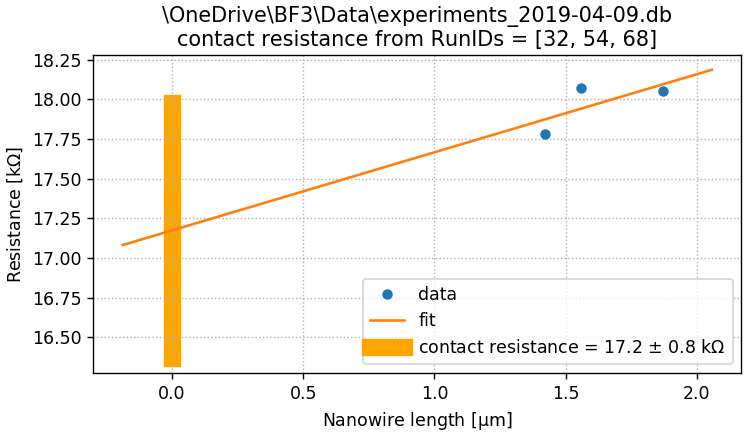

(17173.74828097233, 807.1308594825075)

In [337]:
IDs = [32, 54, 68]
Ls = np.array([1.56, 1.42, 1.87])*1e-6
Vbias = 10e-3

TLM_contact_resistance(IDs, Ls, Vbias)

##  Run IDs 28-33,42-45, TLM2_B9B8

In [43]:
IDs = [28,29,30,31,32,33,44,45,42,43]
biases = np.array([10,10,10,10,10,10,1,1,0,0])*1e-3 # V
L = 1.56e-6 # m

#I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L, reverse_g=True)

##  Run IDs 35-40, TLM2_B9B6

In [51]:
IDs = [35,36,37,38,39,40]
biases = np.array([10,10,1,1,0,0])*1e-3 # V
L = 1.56e-6 + 1.42e-6 # m

#I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L, reverse_g=True)

##  Run IDs 47-52, TLM2_B9B5

In [52]:
IDs = [47,48,49,50,51,52]
biases = np.array([10,10,1,1,0,0])*1e-3 # V
L = 1.56e-6 + 1.42e-6 + 1.87e-6 # m

#I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L, reverse_g=True)

##  Run IDs 54-59, TLM2_B8B6

In [53]:
IDs = [54,55,56,57,58,59]
biases = np.array([10,10,1,1,0,0])*1e-3 # V
L = 1.42e-6 # m

#I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L, reverse_g=True)

##  Run IDs 61-66, TLM2_B8B5

In [54]:
IDs = [61,62,63,64,65,66]
biases = np.array([10,10,1,1,0,0])*1e-3 # V
L = 1.42e-6 + 1.87e-6 # m

#I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L, reverse_g=True)

##  Run IDs 68-73, TLM2_B6B5

In [55]:
IDs = [68,69,70,71,72,73]
biases = np.array([10,10,1,1,0,0])*1e-3 # V
L = 1.87e-6 # m

#I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L, reverse_g=True)

## Run IDs 76-80, FEM1

In [56]:
IDs = [77,78,79,80]
biases = np.array([10,10,0,0])*1e-3 # V
L = 1.93e-6 # m

#I_feel_good = plot_FEM1_pinchoff(IDs, biases, where_I_save_plots, L=L, reverse_g=True)

## Run IDs 91-94, FEM3

In [57]:
IDs = [91,92,93,94]
biases = np.array([10,10,0,0])*1e-3 # V
L = 2.92e-6 # m

#I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L, reverse_g=True)

## Run IDs 83-86,115-120, QPC2

In [58]:
IDs = [83,84,85,86,115,116,117,118,119,120]
biases = np.array([10,10,0,0,10,10,10,10,0,0])*1e-3 # V
L = 0.74e-6 # m

#I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L, reverse_g=True)

## Run IDs 111-114, QPC3

In [59]:
IDs = [111,112,113,114]
biases = np.array([10,10,0,0])*1e-3 # V
L = 0.76e-6 # m

#I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L)

## Run IDs 96,97, AB2

In [60]:
IDs = [96,97,96,97]
biases = np.array([0.1,0.1,0,0])*1e-3 # V
L = 0.76e-6 # m

#I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L, fit=False, show_L=False)

## Run IDs 99-104, HB2

In [61]:
IDs = [99,100,101,102,103,104]
biases = np.array([10,10,10,10,10,10])*1e-3 # V
L = np.array([3.44, 1.39, 1.46])*1e-6 # m

#I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L)

## Run IDs 105-110, HB3

In [62]:
IDs = [105,106,107,108,109,110]
biases = np.array([10,10,10,10,10,10])*1e-3 # V
L = np.array([3.63, 1.32, 1.34])*1e-6 # m

#I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L)

## Run ID 122, QPC2

In [63]:
RunID = 122
dat = load_by_id(RunID)

gate_voltage = dat.get_data('mdac_PG_voltage')
lockin_dc = dat.get_data('lockin_dc')
conductance = dat.get_data('conductance')

PG, bias, _, g_forth, g_back = unpack_back_and_forth(lockin_dc, gate_voltage, conductance)

#fig, ax = colorplot_ForwardBackward(PG, bias, (g_forth, g_back), vmax=5, xlabel='Bias [mV]', xscale=1e3)
#plt.suptitle(pretty_path(experiment_date) + '    RunID: ' + str(RunID), size='large')
#where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID)
#plt.savefig(where, dpi=300)

## Run ID 123, QPC2

In [64]:
RunID = 123
dat = load_by_id(RunID)

gate_voltage = dat.get_data('mdac_PG_voltage')
lockin_dc = dat.get_data('lockin_dc')
conductance = dat.get_data('conductance')

PG, bias, _, g_forth, g_back = unpack_back_and_forth(lockin_dc, gate_voltage, conductance)

#fig, ax = colorplot_ForwardBackward(PG, bias, (g_forth, g_back), vmax=5, xlabel='Bias [mV]', xscale=1e3)
#plt.suptitle(pretty_path(experiment_date) + '    RunID: ' + str(RunID), size='large')
#where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID)
#plt.savefig(where, dpi=300)

# 2019-04-10.db

In [6]:
experiment_date = '2019-04-10'

qc.config["core"]["db_location"] = path(where_db_files_are, experiment_date)

initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists

## Run IDs 3,6, HB2, pinchoffs

<IPython.core.display.Javascript object>


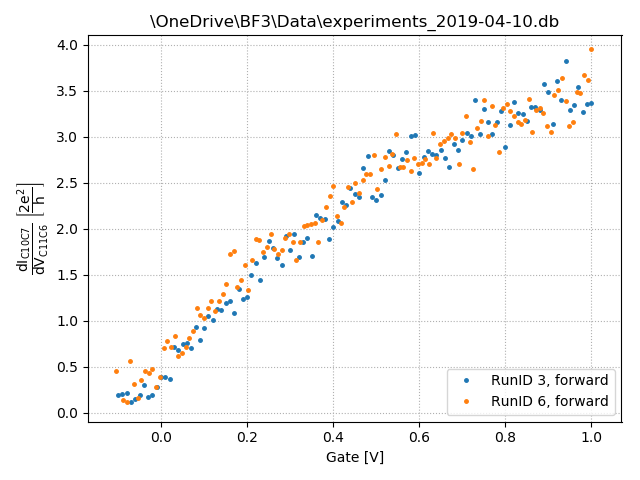

In [7]:
RunIDs = [3, 6]
plt.figure(1).set_tight_layout(True)
ylabel = '$\\dfrac{{\\mathrm{dI_{{C10C7}}}}}{{\\mathrm{dV_{{C11C6}}}}}$'
ylabel_units = '$\\left[\\dfrac{{2\\mathrm{e}^2}}{{\\mathrm{h}}}\\right]$'
ylabel = ylabel + ' ' + ylabel_units
for i in range(len(RunIDs)):
    dat = load_by_id(RunIDs[i])
    gxx = dat.get_data('g_xx')
    PG = dat.get_data('mdac_PG_voltage')
    plot_g_pinchoff(RunIDs[i], PG, gxx, set_ylim=True, ylabel=ylabel)
plt.xlim(-0.17, 1.07)
plt.ylim(-0.1,4.1)
plt.title(pretty_path(experiment_date), size='large')
where = 'Albertos_plots/' + experiment_date + '_RunID-' + str(RunIDs[0]) + '-' + str(RunIDs[-1])
plt.savefig(where, dpi=300)

## Run IDs 14-15, HB2, field sweeps @ gate=1

In [8]:
### everything is in the notebook Q0243_Hall_Bar_mobility

## Run ID 16, HB2, 2D field-gate sweep

In [9]:
RunID = 16
dat = load_by_id(RunID)
Bx = dat.get_data('AMI430_x_field')
PG = dat.get_data('mdac_PG_voltage')
gxx = dat.get_data('g_xx')
phase1 = dat.get_data('Lockin1_phase')

### gxx colorplot

<IPython.core.display.Javascript object>


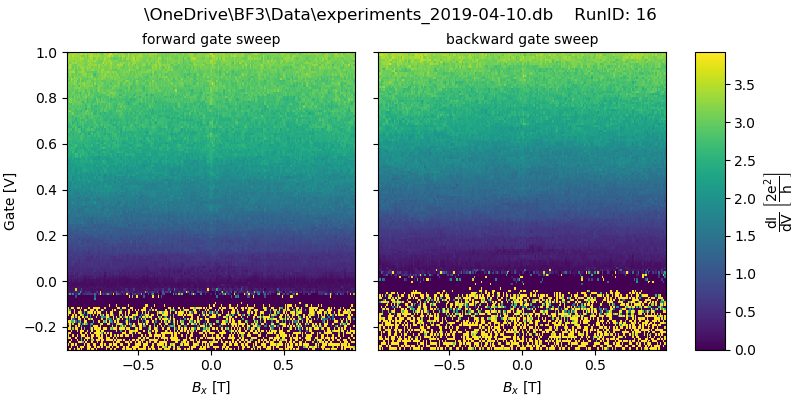

In [10]:
Bx_, PG_forth, PG_back, gxx_forth, gxx_back = unpack_back_and_forth(Bx, PG, gxx)

fig, ax = colorplot_ForwardBackward(Bx_, PG_forth, (gxx_forth, gxx_back))
plt.suptitle(pretty_path(experiment_date) + '    RunID: ' + str(RunID), size='large')
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID)
plt.savefig(where, dpi=300)

<IPython.core.display.Javascript object>


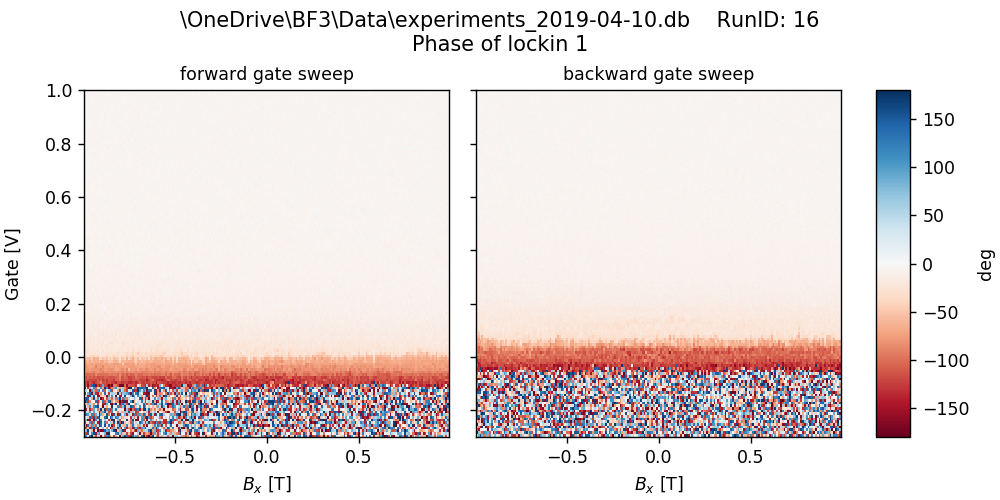

In [69]:
Bx_, PG_forth, PG_back, phase1_forth, phase1_back = unpack_back_and_forth(Bx, PG, phase1)

fig, ax = colorplot_phase_ForwardBackward(Bx_, PG_forth, (phase1_forth, phase1_back))
plt.suptitle(pretty_path(experiment_date) + '    RunID: ' + str(RunID) + '\nPhase of lockin 1', size='large')
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID) + 'phase1'
plt.savefig(where, dpi=300)

<IPython.core.display.Javascript object>


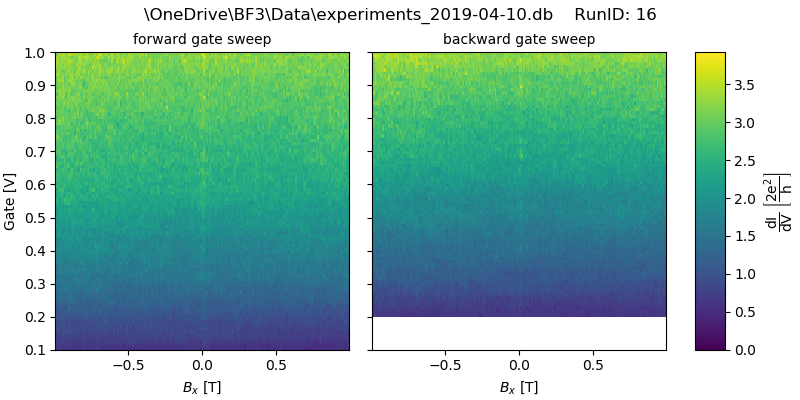

In [11]:
fig, ax = colorplot_ForwardBackward(Bx_, PG_forth, (gxx_forth, gxx_back), forward_cut=0.1, backward_cut=0.2)
plt.suptitle(pretty_path(experiment_date) + '    RunID: ' + str(RunID), size='large')
ax[0].set_ylim(0.1,1)
ax[1].set_ylim(0.1,1)
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID) + '_cutted'
plt.savefig(where, dpi=300)

<IPython.core.display.Javascript object>


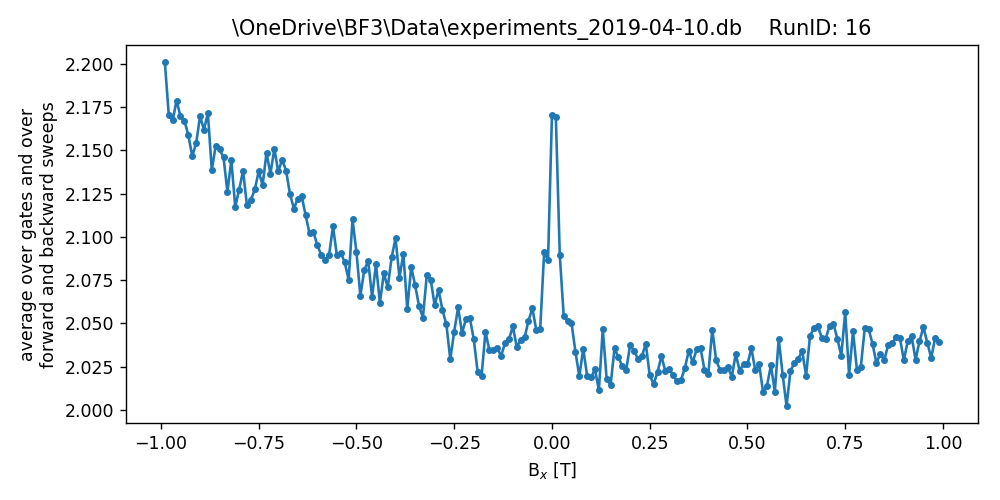

In [70]:
plt.figure('average').set_tight_layout(True)
a = brute_meaningless_gate_average(Bx_, PG_forth, gxx_forth, cut=0.1)
b = brute_meaningless_gate_average(Bx_, PG_forth[::-1], gxx_back, cut=0.2)
c = (91*a + 81*b) / 172
#plt.plot(Bx_, a, '.-')
#plt.plot(Bx_, b, '.-')
plt.plot(Bx_, c, '.-')
plt.xlabel('B$_x$ [T]')
plt.ylabel('average over gates and over\nforward and backward sweeps')
plt.title(pretty_path(experiment_date) + '    RunID: ' + str(RunID), size='large')
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID) + '_brute_meaningless_average'
plt.savefig(where, dpi=300)

### Hall bar mobility

In [12]:
w = 190e-9 # A
Lxx = 1.99e-6 # m

In [13]:
Bx = np.array(dat.get_values('AMI430_x_field'))
PG = np.array(dat.get_values('mdac_PG_voltage'))
Rxx = np.array(dat.get_values('R_xx'))
#gxx = np.array(dat.get_values('g_xx'))
Rxyj1 = np.array(dat.get_values('R_xy_j1'))
Rxyj2 = np.array(dat.get_values('R_xy_j2'))

In [14]:
Bx_, PG_forth, PG_back, Rxx_forth, Rxx_back = unpack_back_and_forth(Bx, PG, Rxx)
_, __, ___, Rxyj1_forth, Rxyj1_back = unpack_back_and_forth(Bx, PG, Rxyj1)
_, __, ___, Rxyj2_forth, Rxyj2_back = unpack_back_and_forth(Bx, PG, Rxyj2)

In [15]:
mus_forth, dmus_forth = hall_bar_mobilities(Bx_, Rxx_forth, Rxyj1_forth, Lxx, w)
mus_back, dmus_back = hall_bar_mobilities(Bx_, Rxx_back, Rxyj1_back, Lxx, w)

<IPython.core.display.Javascript object>


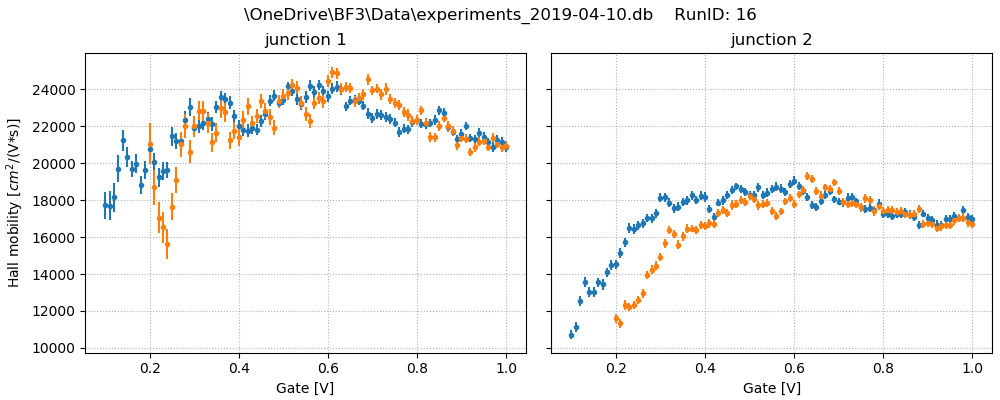

In [16]:
params = {'legend.fontsize': 'medium',
              'figure.figsize': (10, 4),
              'axes.labelsize': 'medium',
              'axes.titlesize':'large',
              'xtick.labelsize':'medium',
              'ytick.labelsize':'medium'}
mpl.rcParams.update(params)
fig, axes = plt.subplots(ncols=2, nrows=1, sharey=True, constrained_layout=True)
plt.suptitle(pretty_path(experiment_date) + '    RunID: ' + str(RunID), size='large')
axes[0].set(ylabel='Hall mobility [$cm^2$/(V*s)]')
Rxy_forths = (Rxyj1_forth, Rxyj2_forth)
Rxy_backs = (Rxyj1_back, Rxyj2_back)
for i, ax in enumerate(axes):
    mus_forth, dmus_forth = hall_bar_mobilities(Bx_, Rxx_forth, Rxy_forths[i], Lxx, w)
    mus_back, dmus_back = hall_bar_mobilities(Bx_, Rxx_back, Rxy_backs[i], Lxx, w)
    ax.errorbar(PG_forth[PG_forth>=0.1], mus_forth[PG_forth>=0.1]*1e4, fmt='.', yerr=dmus_forth[PG_forth>=0.1]*1e4)
    ax.errorbar(PG_back[PG_back>=0.2], mus_back[PG_back>=0.2]*1e4, fmt='.', yerr=dmus_back[PG_back>=0.2]*1e4)
    ax.set(xlabel='Gate [V]', title='junction {}'.format(i+1))
    ax.grid(linestyle=':')
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID) + '_hall_mobility'
plt.savefig(where, dpi=300)

<IPython.core.display.Javascript object>


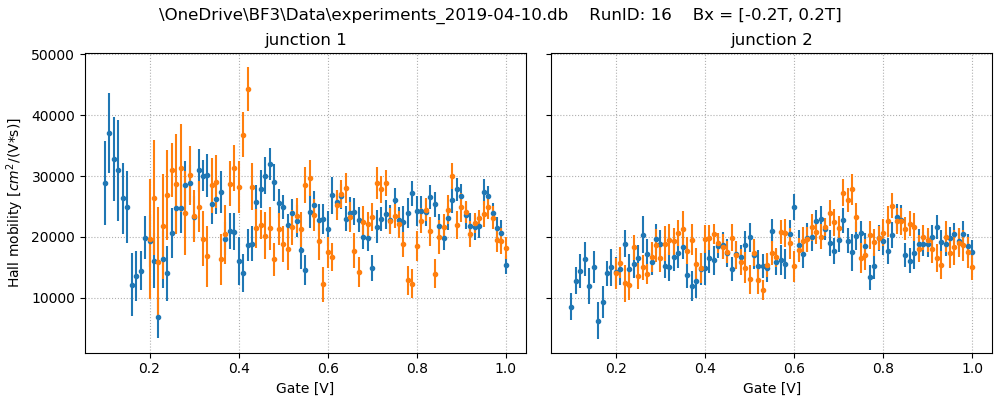

In [17]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharey=True, constrained_layout=True)
plt.suptitle(pretty_path(experiment_date) + '    RunID: ' + str(RunID) + '    Bx = [-0.2T, 0.2T]', size='large')
axes[0].set(ylabel='Hall mobility [$cm^2$/(V*s)]')
Rxy_forths = (Rxyj1_forth, Rxyj2_forth)
Rxy_backs = (Rxyj1_back, Rxyj2_back)
for i, ax in enumerate(axes):
    Bx_temp = Bx_
    Bx_cutted = Bx_temp[np.logical_and(Bx_>=-0.2, Bx_<=0.2)]
    Rxx_forth_cutted = Rxx_forth[np.logical_and(Bx_>=-0.2, Bx_<=0.2)]
    Rxy_forth_cutted = Rxy_forths[i][np.logical_and(Bx_>=-0.2, Bx_<=0.2)]
    Rxx_back_cutted = Rxx_back[np.logical_and(Bx_>=-0.2, Bx_<=0.2)]
    Rxy_back_cutted = Rxy_backs[i][np.logical_and(Bx_>=-0.2, Bx_<=0.2)]
    mus_forth, dmus_forth = hall_bar_mobilities(Bx_cutted, Rxx_forth_cutted, Rxy_forth_cutted, Lxx, w)
    mus_back, dmus_back = hall_bar_mobilities(Bx_cutted, Rxx_back_cutted, Rxy_back_cutted, Lxx, w)
    ax.errorbar(PG_forth[PG_forth>=0.1], mus_forth[PG_forth>=0.1]*1e4, fmt='.', yerr=dmus_forth[PG_forth>=0.1]*1e4)
    ax.errorbar(PG_back[PG_back>=0.2], mus_back[PG_back>=0.2]*1e4, fmt='.', yerr=dmus_back[PG_back>=0.2]*1e4)
    ax.set(xlabel='Gate [V]', title='junction {}'.format(i+1))
    ax.grid(linestyle=':')
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID) + '_hall_mobility_Bx_cutted'
plt.savefig(where, dpi=300)

# 2019-04-11.db

In [7]:
experiment_date = '2019-04-11'

qc.config["core"]["db_location"] = path(where_db_files_are, experiment_date)

initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists

## RunID 6, HB2, 2D field-gate sweep

In [8]:
RunID = 6
dat = load_by_id(RunID)
Bx = dat.get_data('AMI430_x_field')
PG = dat.get_data('mdac_PG_voltage')
gxx = dat.get_data('g_xx')
phase1 = dat.get_data('Lockin1_phase')
Rxx = np.array(dat.get_values('R_xx'))
Rxyj1 = np.array(dat.get_values('R_xy_j1'))
Rxyj2 = np.array(dat.get_values('R_xy_j2'))

<IPython.core.display.Javascript object>


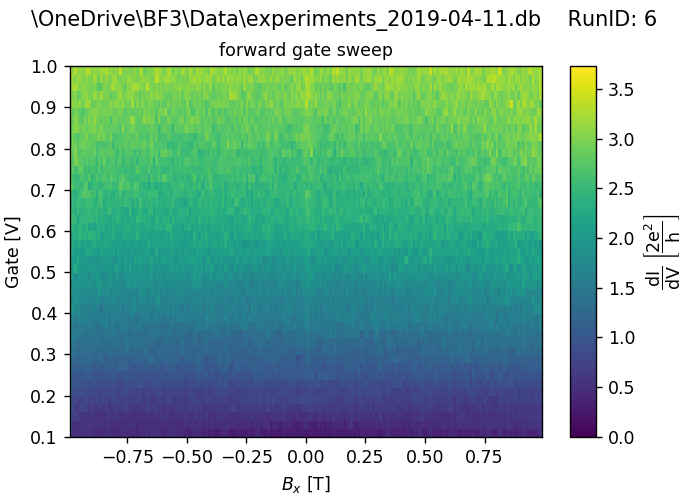

In [9]:
Bx_, PG_forth, gxx_forth = unpack_2D_sweep(Bx, PG, gxx)

fig, ax = colorplot_Forward(Bx_, PG_forth, gxx_forth, cut=0.1)
plt.suptitle(pretty_path(experiment_date) + '    RunID: ' + str(RunID), size='large')
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID)
plt.savefig(where, dpi=300)

<IPython.core.display.Javascript object>


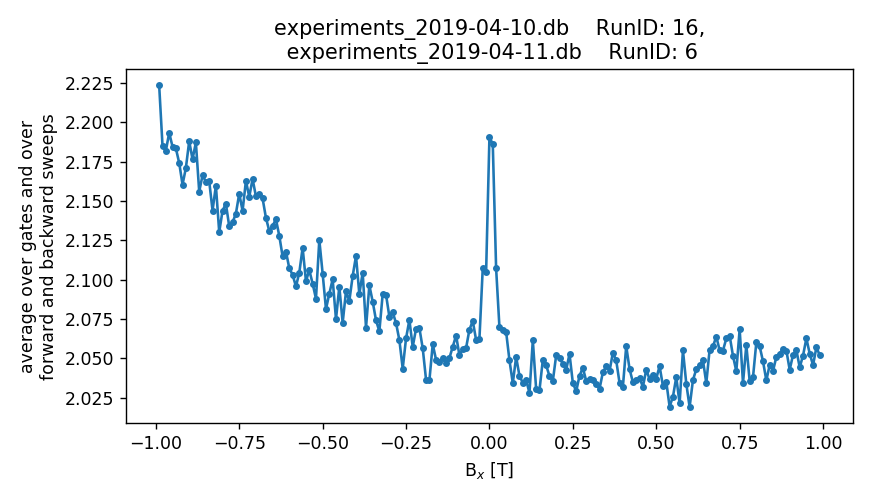

In [77]:
plt.figure('average2therevenge', figsize=(7,4)).set_tight_layout(True)
#c = (91*a + 81*b) / 172
d = brute_meaningless_gate_average(Bx_, PG_forth, gxx_forth, cut=0.1)
e = (172*c + 46*d) / 218
#plt.plot(Bx_, c, '.-')
#plt.plot(Bx_, d, '.-')
plt.plot(Bx_, e, '.-')
plt.xlabel('B$_x$ [T]')
plt.ylabel('average over gates and over\nforward and backward sweeps')
plt.title('experiments_2019-04-10.db    RunID: 16,\n experiments_2019-04-11.db    RunID: 6', size='large')
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID) + '_brute_meaningless_average'
plt.savefig(where, dpi=300)

In [10]:
Bx_, PG_forth, Rxx_forth = unpack_2D_sweep(Bx, PG, Rxx)
_, __, Rxyj1_forth = unpack_2D_sweep(Bx, PG, Rxyj1)
_, __, Rxyj2_forth = unpack_2D_sweep(Bx, PG, Rxyj2)

mus_forth, dmus_forth = hall_bar_mobilities(Bx_, Rxx_forth, Rxyj1_forth, Lxx, w)

params = {'legend.fontsize': 'medium',
              'figure.figsize': (10, 4),
              'axes.labelsize': 'medium',
              'axes.titlesize':'large',
              'xtick.labelsize':'medium',
              'ytick.labelsize':'medium'}
mpl.rcParams.update(params)
fig, axes = plt.subplots(ncols=2, nrows=1, sharey=True, constrained_layout=True)
plt.suptitle(pretty_path(experiment_date) + '    RunID: ' + str(RunID), size='large')
axes[0].set(ylabel='Hall mobility [$cm^2$/(V*s)]')
Rxy_forths = (Rxyj1_forth, Rxyj2_forth)
for i, ax in enumerate(axes):
    mus_forth, dmus_forth = hall_bar_mobilities(Bx_, Rxx_forth, Rxy_forths[i], Lxx, w)
    ax.errorbar(PG_forth[PG_forth>=0.1], mus_forth[PG_forth>=0.1]*1e4, fmt='.', yerr=dmus_forth[PG_forth>=0.1]*1e4)
    ax.set(xlabel='Gate [V]', title='junction {}'.format(i+1))
    ax.grid(linestyle=':')
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID) + '_hall_mobility'
plt.savefig(where, dpi=300)

NameError: name 'Lxx' is not defined

## RunID 13, HB3, 2D field-gate sweeps

### Geometrical parameters

In [136]:
w = 190e-9 # A
Lxx = 1.97e-6 # m

In [137]:
RunID = 13
dat = load_by_id(RunID)

In [138]:
Bx = np.array(dat.get_values('AMI430_x_field'))
PG = np.array(dat.get_values('mdac_PG_voltage'))
gxx = np.array(dat.get_values('g_xx'))
Rxx = np.array(dat.get_values('R_xx'))
#gxx = np.array(dat.get_values('g_xx'))
Rxyj2 = np.array(dat.get_values('R_xy_j2'))
phase1 = dat.get_data('Lockin1_phase')

<IPython.core.display.Javascript object>


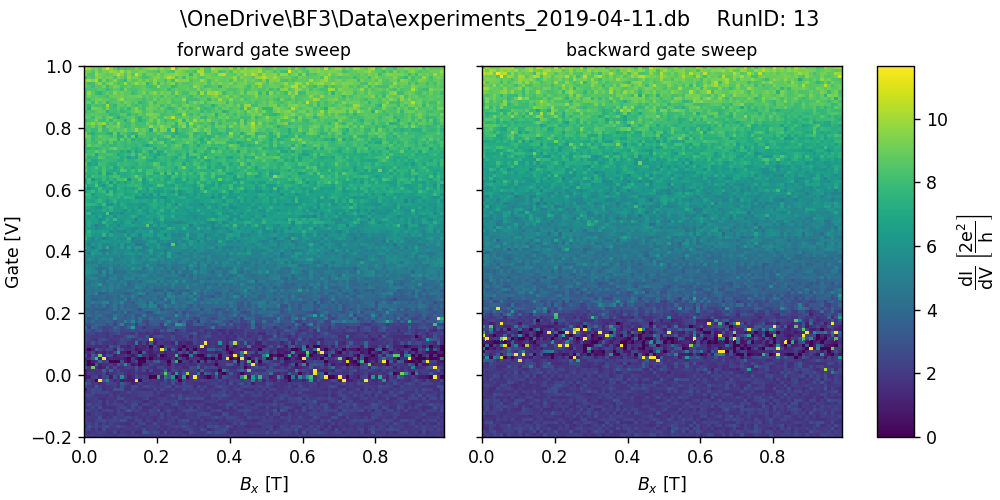

In [139]:
Bx_, PG_forth, PG_back, gxx_forth, gxx_back = unpack_back_and_forth(Bx, PG, gxx)

fig, ax = colorplot_ForwardBackward(Bx_, PG_forth, (gxx_forth, gxx_back))
plt.suptitle(pretty_path(experiment_date) + '    RunID: ' + str(RunID), size='large')
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID)
plt.savefig(where, dpi=300)

<IPython.core.display.Javascript object>


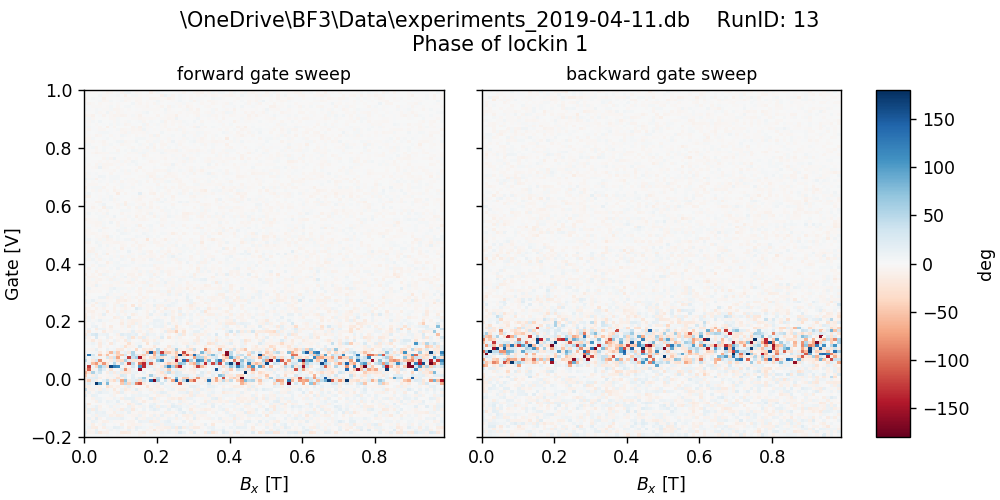

In [60]:
Bx_, PG_forth, PG_back, phase1_forth, phase1_back = unpack_back_and_forth(Bx, PG, phase1)

fig, ax = colorplot_phase_ForwardBackward(Bx_, PG_forth, (phase1_forth, phase1_back))
plt.suptitle(pretty_path(experiment_date) + '    RunID: ' + str(RunID) + '\nPhase of lockin 1', size='large')
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID) + 'phase1'
plt.savefig(where, dpi=300)

<IPython.core.display.Javascript object>


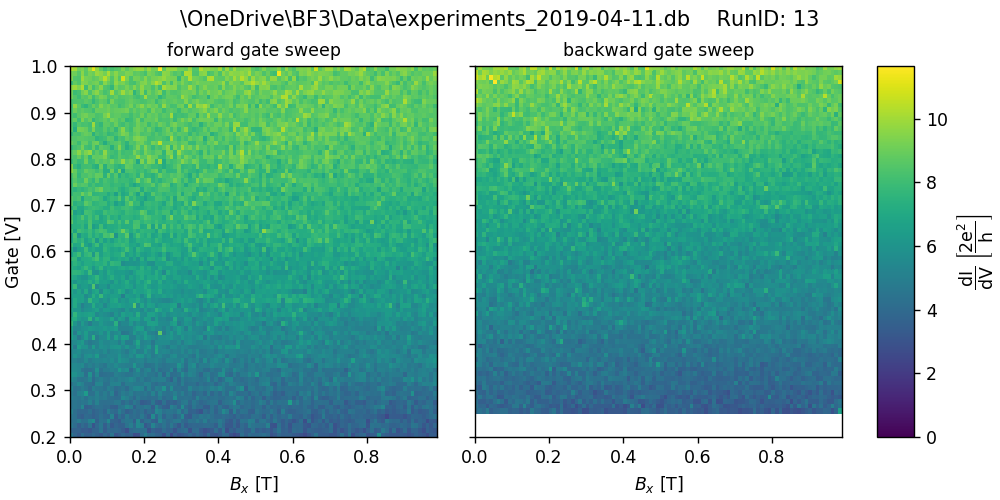

In [140]:
fig, ax = colorplot_ForwardBackward(Bx_, PG_forth, (gxx_forth, gxx_back), forward_cut=0.2, backward_cut=0.25)
plt.suptitle(pretty_path(experiment_date) + '    RunID: ' + str(RunID), size='large')
ax[0].set_ylim(0.2,1)
ax[1].set_ylim(0.2,1)
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID) + '_cutted'
plt.savefig(where, dpi=300)

In [143]:
Bx_, PG_forth, PG_back, Rxx_forth, Rxx_back = unpack_back_and_forth(Bx, PG, Rxx)
_, __, ___, Rxyj2_forth, Rxyj2_back = unpack_back_and_forth(Bx, PG, Rxyj2)

<IPython.core.display.Javascript object>


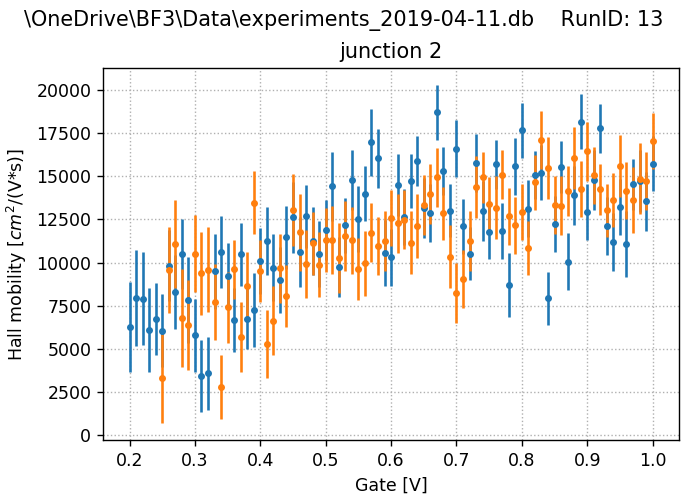

In [144]:
params = {'legend.fontsize': 'medium',
              'figure.figsize': (5.5, 4),
              'axes.labelsize': 'medium',
              'axes.titlesize':'large',
              'xtick.labelsize':'medium',
              'ytick.labelsize':'medium'}
mpl.rcParams.update(params)
fig, ax = plt.subplots(ncols=1, nrows=1, sharey=True, constrained_layout=True)
plt.suptitle(pretty_path(experiment_date) + '    RunID: ' + str(RunID), size='large')
mus_forth, dmus_forth = hall_bar_mobilities(Bx_, Rxx_forth, Rxyj2_forth, Lxx, w)
mus_back, dmus_back = hall_bar_mobilities(Bx_, Rxx_back, Rxyj2_back, Lxx, w)
ax.errorbar(PG_forth[PG_forth>=0.2], mus_forth[PG_forth>=0.2]*1e4, fmt='.', yerr=dmus_forth[PG_forth>=0.2]*1e4)
ax.errorbar(PG_back[PG_back>=0.25], mus_back[PG_back>=0.25]*1e4, fmt='.', yerr=dmus_back[PG_back>=0.25]*1e4)
ax.set(xlabel='Gate [V]',ylabel='Hall mobility [$cm^2$/(V*s)]', title='junction 2')
ax.grid(linestyle=':')
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID) + '_hall_mobility'
plt.savefig(where, dpi=300)

## RunID 12, HB3, 2D field-gate sweep

In [145]:
RunID = 12
dat = load_by_id(RunID)

<IPython.core.display.Javascript object>


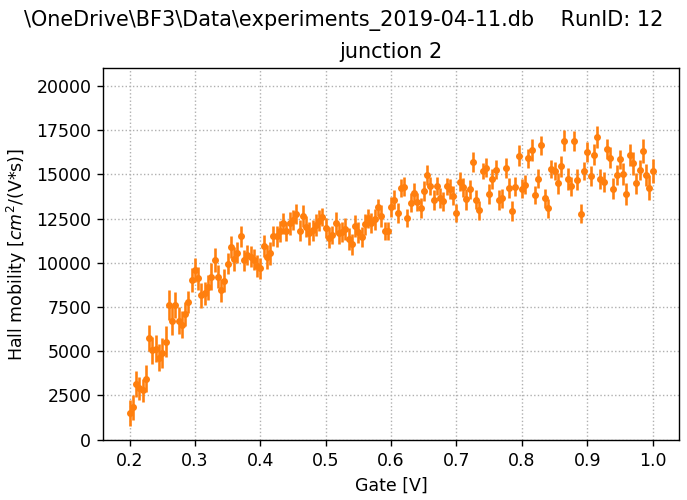

In [146]:
RunID = 12
dat = load_by_id(RunID)

Bx = np.array(dat.get_values('AMI430_x_field'))
PG = np.array(dat.get_values('mdac_PG_voltage'))
gxx = np.array(dat.get_values('g_xx'))
Rxx = np.array(dat.get_values('R_xx'))
#gxx = np.array(dat.get_values('g_xx'))
Rxyj2 = np.array(dat.get_values('R_xy_j2'))

Bx_, PG_, Rxx_ = unpack_2D_sweep(Bx, PG, Rxx)
_, __, Rxyj2_ = unpack_2D_sweep(Bx, PG, Rxyj2)

fig, ax = plt.subplots(ncols=1, nrows=1, sharey=True, constrained_layout=True)
plt.suptitle(pretty_path(experiment_date) + '    RunID: ' + str(RunID), size='large')
muss_, dmuss_ = hall_bar_mobilities(Bx_, Rxx_, Rxyj2_, Lxx, w)
ax.errorbar(PG_[::-1], muss_*1e4, fmt='.', yerr=dmuss_*1e4, color='tab:orange')
ax.set(xlabel='Gate [V]',ylabel='Hall mobility [$cm^2$/(V*s)]', ylim=(0,21000), title='junction 2')
ax.grid(linestyle=':')
#plt.legend()
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID) + '_hall_mobility'
plt.savefig(where, dpi=300)

<IPython.core.display.Javascript object>


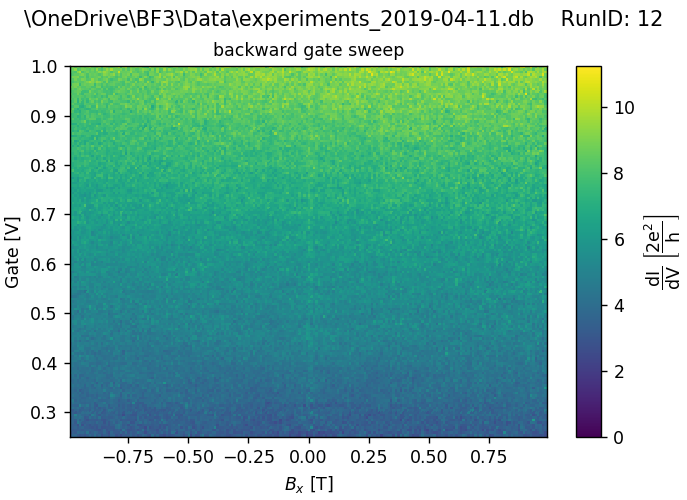

In [150]:
Bx_, PG_forth, gxx_forth = unpack_2D_sweep(Bx, PG, gxx)

fig, ax = colorplot_Backward(Bx_, PG_forth, gxx_forth, cut=0.25)
plt.suptitle(pretty_path(experiment_date) + '    RunID: ' + str(RunID), size='large')
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID)
plt.savefig(where, dpi=300)

<IPython.core.display.Javascript object>


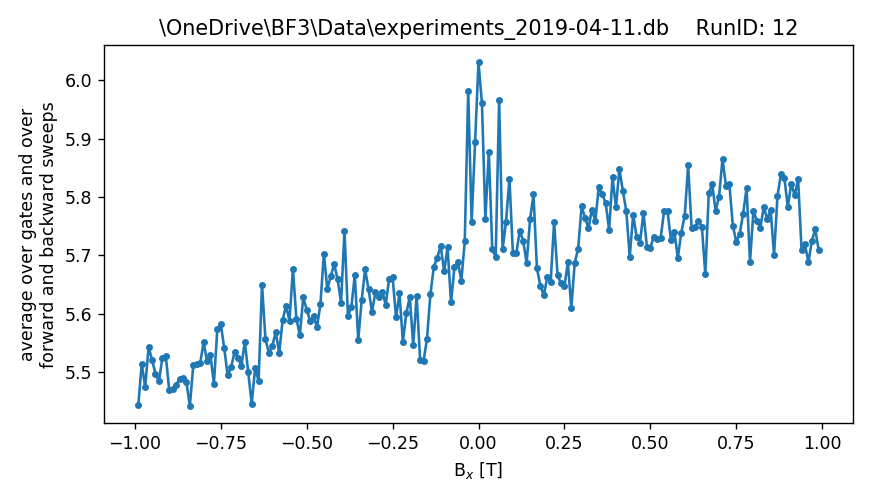

In [151]:
plt.figure('average3endgame', figsize=(7,4)).set_tight_layout(True)
#c = (91*a + 81*b) / 172
f = brute_meaningless_gate_average(Bx_, PG_forth, gxx_forth, cut=0.25)
plt.plot(Bx_, f, '.-')
plt.xlabel('B$_x$ [T]')
plt.ylabel('average over gates and over\nforward and backward sweeps')
plt.title(pretty_path(experiment_date) + '    RunID: ' + str(RunID), size='large')
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID) + '_brute_meaningless_average'
plt.savefig(where, dpi=300)

## Run ID 14, QPC2, pinchoff test

<IPython.core.display.Javascript object>


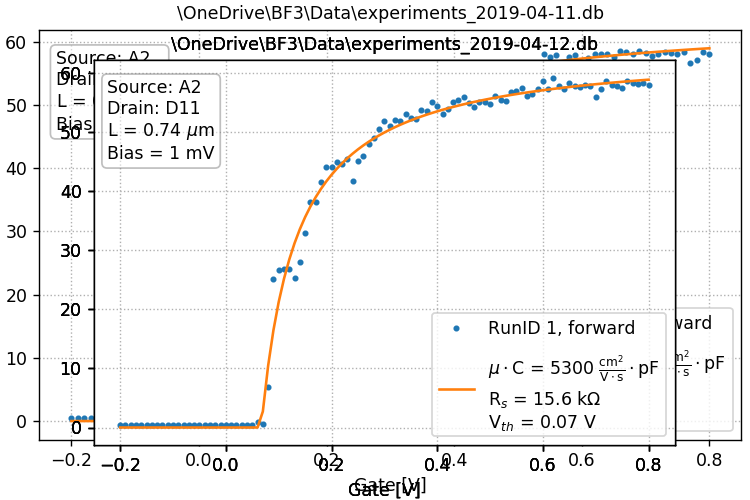

C:\Anaconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: divide by zero encountered in true_divide


mu*C = 5300 (cm^2 / (V*s)) * pF
Rs = 15.6 kOhm
Vth = 0.039 V


In [24]:
RunID = 14
L = 0.74e-6
bias = 1e-3

dat = load_by_id(RunID)
gate = dat.get_data('mdac_PG_voltage')
current = dat.get_data('current')

I_feel_good = plot_single_pinchoff(RunID, gate, current, bias, where_I_save_plots, L=L)

# 2019-04-12.db (my birthday)

In [31]:
experiment_date = '2019-04-12'

qc.config["core"]["db_location"] = path(where_db_files_are, experiment_date)

initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists

<IPython.core.display.Javascript object>


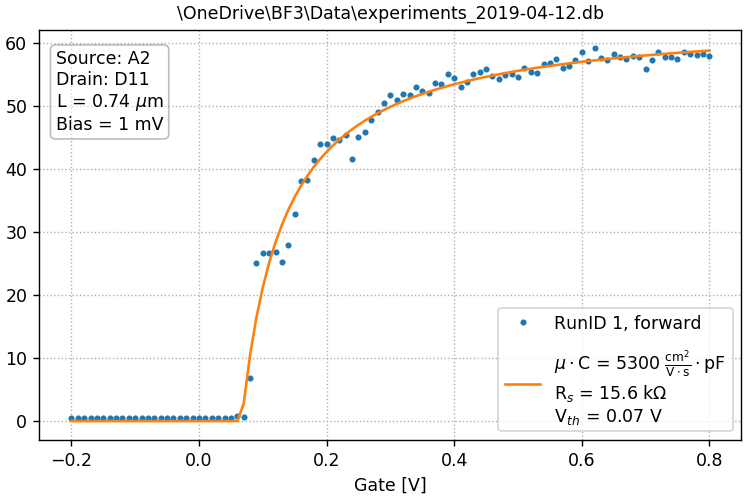

C:\Anaconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:274: RuntimeWarning: divide by zero encountered in true_divide


mu*C = 5300 (cm^2 / (V*s)) * pF
Rs = 15.6 kOhm
Vth = 0.067 V


In [32]:
RunID = 1
L = 0.74e-6
bias = 1e-3

dat = load_by_id(RunID)
gate = dat.get_data('mdac_PG_voltage')
current = dat.get_data('current')

I_feel_good = plot_single_pinchoff(RunID, gate, current, bias, where_I_save_plots, L=L)

## RunID 8, QPC2, 2D gate-bias sweep

<IPython.core.display.Javascript object>


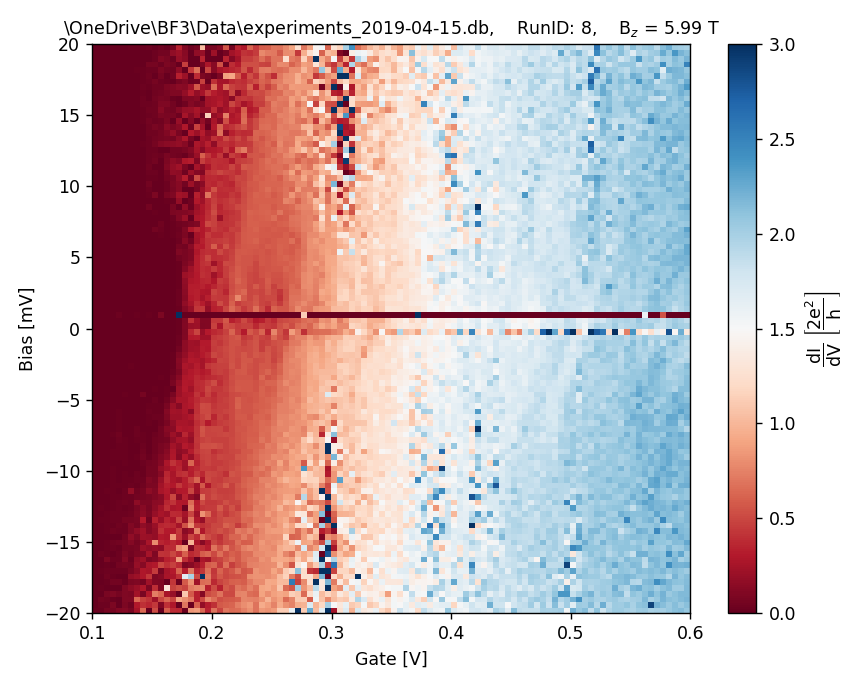

In [74]:
RunID = 8
dat = load_by_id(RunID)
dat.get_parameters()
gate = dat.get_data('mdac_PG_voltage')
bias = dat.get_data('lockin_dc')
g = dat.get_data('conductance')

gate, bias, g = unpack_2D_sweep(gate, bias, g)

params = {'legend.fontsize': 'medium',
          'figure.figsize': (6.9, 5.5),
          'axes.labelsize': 'medium',
          'axes.titlesize':'medium',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'}
mpl.rcParams.update(params)

fig, axes = plt.subplots(ncols=1, nrows=1, sharey=True, tight_layout=True)
cmap = plt.cm.RdBu #viridis it's the default
norm = mpl.colors.Normalize(vmin=0, vmax=3)
im = axes.pcolor(gate, bias*1e3, g.T, cmap=cmap, norm=norm)
title = pretty_path(experiment_date) + ',    RunID: ' + str(RunID)+ ',    B$_z$ = 5.99 T'
axes.set(xlabel='Gate [V]', ylabel='Bias [mV]', title=title)
cbar = fig.colorbar(im, ax=axes)
cbar.ax.set_ylabel(g_label)
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID)
fig.savefig(where, dpi=300)

# 2019-04-15.db

In [33]:
experiment_date = '2019-04-15'

qc.config["core"]["db_location"] = path(where_db_files_are, experiment_date)

initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists

## RunID 15, QPC2, 2D gate-bias sweep

In [37]:
RunID = 15
dat = load_by_id(RunID)
dat.get_parameters()
gate = dat.get_data('mdac_PG_voltage')
bias = dat.get_data('lockin_dc')
g = dat.get_data('conductance')

In [38]:
gate, bias, g = unpack_2D_sweep(gate, bias, g)

<IPython.core.display.Javascript object>


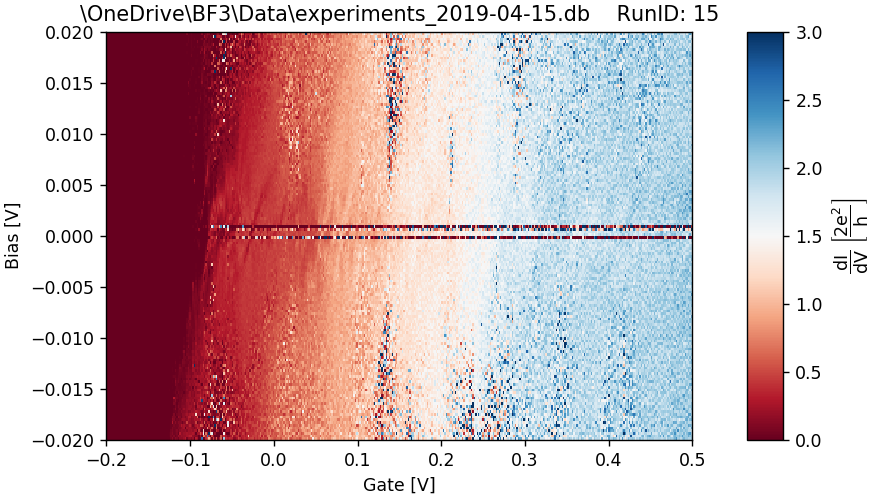

In [60]:
params = {'legend.fontsize': 'medium',
          'figure.figsize': (7, 4),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'}
mpl.rcParams.update(params)

fig, axes = plt.subplots(ncols=1, nrows=1, sharey=True, constrained_layout=True)
cmap = plt.cm.RdBu #viridis it's the default
norm = mpl.colors.Normalize(vmin=0, vmax=3)
im = axes.pcolor(gate, bias, g.T, cmap=cmap, norm=norm)
title = pretty_path(experiment_date) + '    RunID: ' + str(RunID)
axes.set(xlabel='Gate [V]', ylabel='Bias [V]', title=title)
cbar = fig.colorbar(im, ax=axes)
cbar.ax.set_ylabel(g_label)
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID)
fig.savefig(where, dpi=300)

# 2019-04-17.db

In [5]:
experiment_date = '2019-04-17'

qc.config["core"]["db_location"] = path(where_db_files_are, experiment_date)

initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists

## Run IDs 2-4, 6-8, AB2, field sweeps

In [6]:
A_int = 0.05*1e-12 # m^2
A_ext = 0.31*1e-12 # m^2
A_mean = (np.sqrt(A_int) + np.sqrt(A_ext))**2 / 4

B_int = Phi0 / A_int
B_ext = Phi0 / A_ext
B_mean = Phi0 / A_mean

B_inverse_int = 1 / B_int
B_inverse_ext = 1 / B_ext
B_inverse_mean = 1 / B_mean

<IPython.core.display.Javascript object>


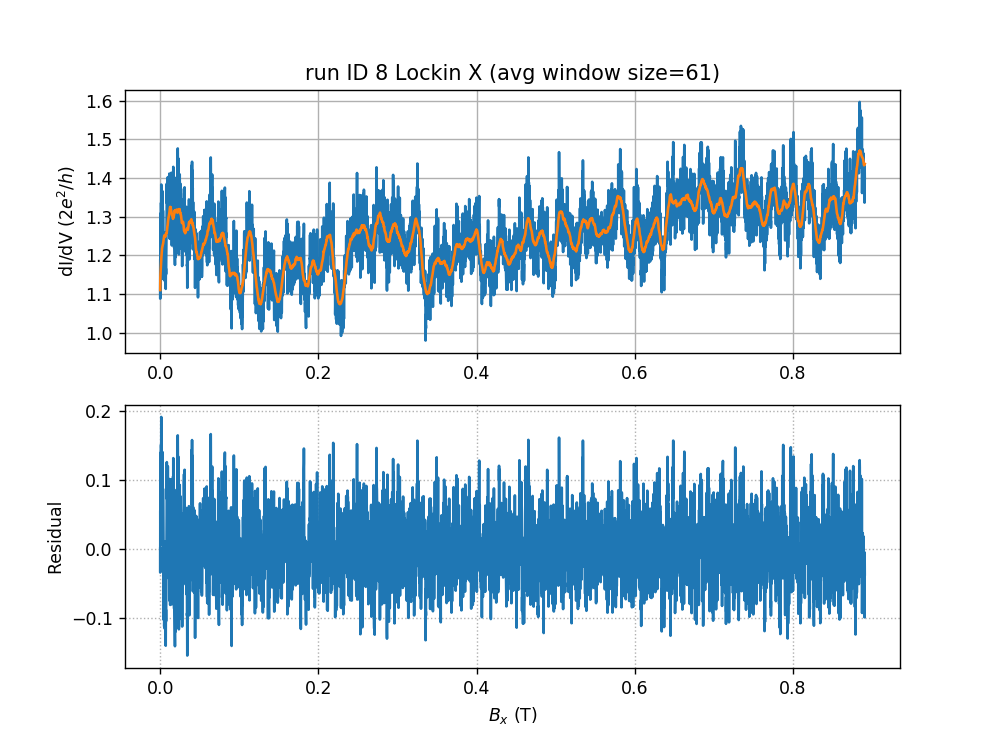

<IPython.core.display.Javascript object>


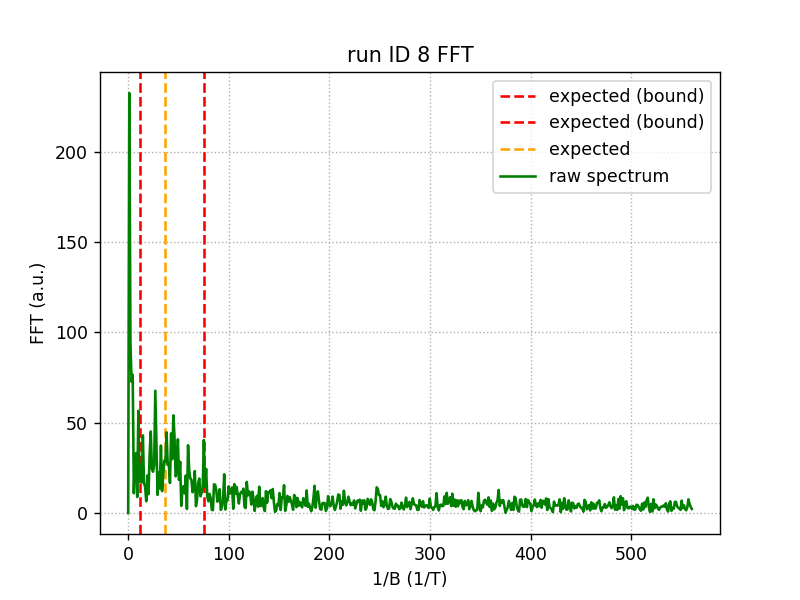

In [96]:
RunID = 8
dat_AB = load_by_id(RunID)

B_values = np.array(dat_AB.get_values('B_x'))[:,0]
B_min, B_max = min(B_values), max(B_values)
npoints = B_values.size
conductance_values = np.array(dat_AB.get_values('conductance'))[:,0]

avg_window_size = 61
conductance_background = smooth(conductance_values, avg_window_size, 1) # 31 points ~ 15mT, close to expected period
conductance_residual = conductance_values - conductance_background

plt.figure('fft background RunID '+ str(RunID), figsize=(8,6))
plt.subplot(211)
plt.plot(B_values, conductance_values, B_values, conductance_background)
plt.grid(b=True)
plt.title('run ID ' + '{}'.format(dat_AB.run_id) + ' Lockin X (avg window size=' + str(avg_window_size) + ')')
plt.ylabel('dI/dV ($2e^2/h$)')
plt.subplot(212)
plt.plot(B_values, conductance_residual)
plt.ylabel('Residual')
plt.xlabel('$B_x$ (T)')
plt.grid(linestyle=':', b=True)
where0 = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID)
plt.savefig(where0 + '_smoothing', dpi=300)

# FFT
n_cutoff = 500

fft_ab = np.fft.fft(conductance_residual)
fft_non_avgd = np.fft.fft(conductance_values - conductance_values.mean())
B_inv = np.linspace(0, npoints/(B_max-B_min), npoints)

plt.figure('abfft RunID '+ str(RunID))
plt.axvline(x=B_inverse_int, color='red', linestyle='dashed',label='expected (bound)')
plt.axvline(x=B_inverse_ext, color='red', linestyle='dashed', label='expected (bound)')
plt.axvline(x=B_inverse_mean, color='orange', linestyle='dashed', label='expected')
#plt.plot(B_inv[:n_cutoff], np.abs(fft_ab)[:n_cutoff]+1, label='subtracted background')
plt.plot(B_inv[:n_cutoff], np.abs(fft_non_avgd)[:n_cutoff], color='green', label='raw spectrum')
plt.xlabel('1/B (1/T)')
plt.ylabel('FFT (a.u.)')
plt.title('run ID ' + '{}'.format(dat_AB.run_id) + ' FFT')
plt.legend()
plt.grid(linestyle=':', b=True)
plt.savefig(where0 + '_FFT', dpi=300)

<IPython.core.display.Javascript object>


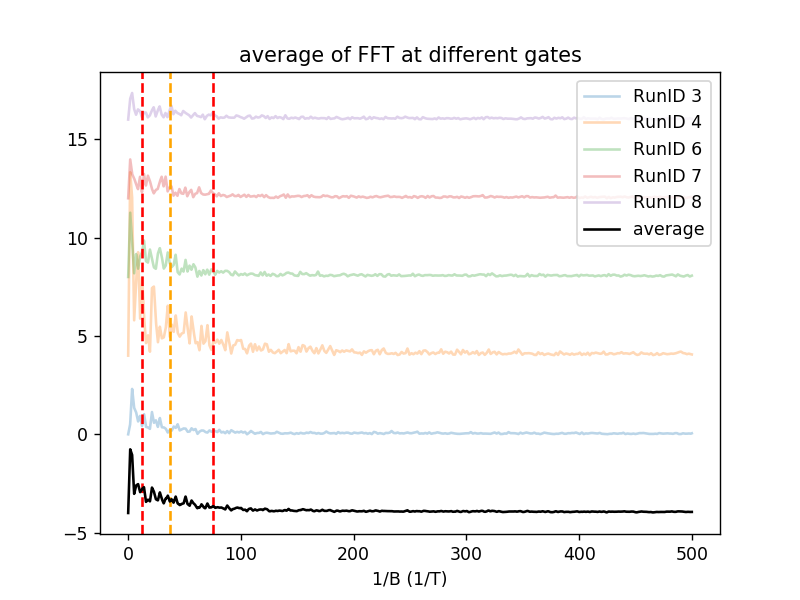

In [94]:
data_id_list = [3,4,6,7,8]
RunIDs = ''
for i in range(len(data_id_list)):
    RunIDs = RunIDs + ' ' + str(data_id_list[i])
    
# data_id_list = range(861,874)
# data_id_list = range(920,940)
number_points_list = [4000,4000,4000,4000]
n_cutoff = 5000

B_inv_unified = np.linspace(0,2000,20001)
fft_avg = np.zeros(B_inv_unified.shape)

plt.figure('all AB raw')

counter = 0
for data_id in data_id_list:
    dat_AB = load_by_id(data_id)
    B_values = np.array(dat_AB.get_values('B_x'))[:4000,0]
    B_min, B_max = min(B_values), max(B_values)
    npoints = B_values.size
    conductance_values = np.array(dat_AB.get_values('Lockin1_X'))[:4000,0]
    
    avg_window_size = 101
    conductance_background = smooth(conductance_values, avg_window_size, 1) # 31 points ~ 15mT, close to expected period
    conductance_residual = conductance_values - conductance_background
    
    #fft_ab = np.abs(np.fft.fft(conductance_residual))
    fft_ab = np.abs(np.fft.fft(conductance_values - conductance_values.mean()))
    B_inv = np.linspace(0, npoints/(B_max-B_min), npoints)
    
    fft_ab_intp = np.interp(B_inv_unified, B_inv, fft_ab)
    fft_avg += fft_ab_intp
    
    plt.plot(B_inv_unified[:n_cutoff], 50*fft_ab_intp[:n_cutoff] + 4*counter, alpha = 0.3, label='RunID {}'.format(data_id))
    counter += 1

plt.legend(list(map(str, data_id_list)))
fft_avg /= len(data_id_list)
fft_scalar = 1
plt.axvline(x=B_inverse_int, color='red', linestyle = 'dashed')
plt.axvline(x=B_inverse_ext, color='red', linestyle = 'dashed')
plt.axvline(x=B_inverse_mean, color='orange', linestyle = 'dashed')
plt.plot(B_inv_unified[:n_cutoff], fft_scalar*50*fft_avg[:n_cutoff] - 4, color = 'black', label='average')
# plt.plot(B_inv_unified, savgol_filter(fft_avg*fft_scalar, 31, 3), color = 'black')
plt.title('average of FFT at different gates')
plt.xlabel('1/B (1/T)')
plt.legend(loc=1)
where0 = 'Albertos_plots/' + experiment_date + '_RunID' + RunIDs
plt.savefig(where0 + '_average', dpi=300)

## Run IDs 15-17, QPC3, pinchoffs

<IPython.core.display.Javascript object>


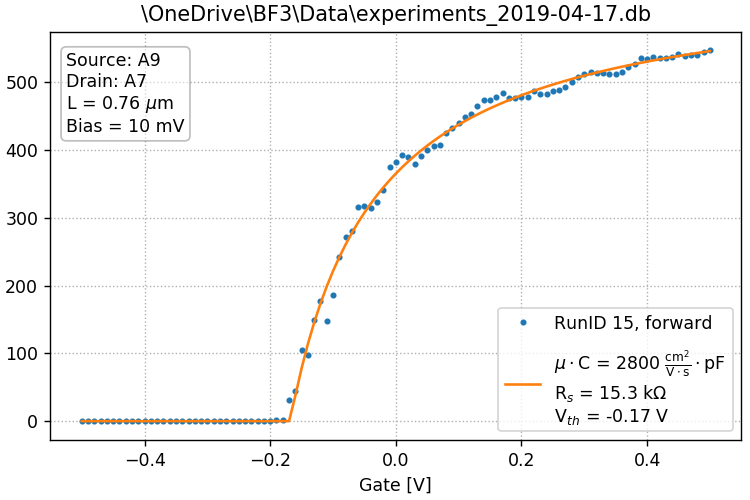

C:\Anaconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide


mu*C = 2800 (cm^2 / (V*s)) * pF
Rs = 15.3 kOhm
Vth = -0.168 V


In [21]:
ID = 15
bias = 10*1e-3 # V
L = 0.76e-6 # m

dat = load_by_id(ID)
gate = dat.get_data('mdac_PG_voltage')
current = dat.get_data('current')
I_feel_good = plot_single_pinchoff(ID, gate, current, bias, where_I_save_plots, L=L, reverse_g=True)

<IPython.core.display.Javascript object>


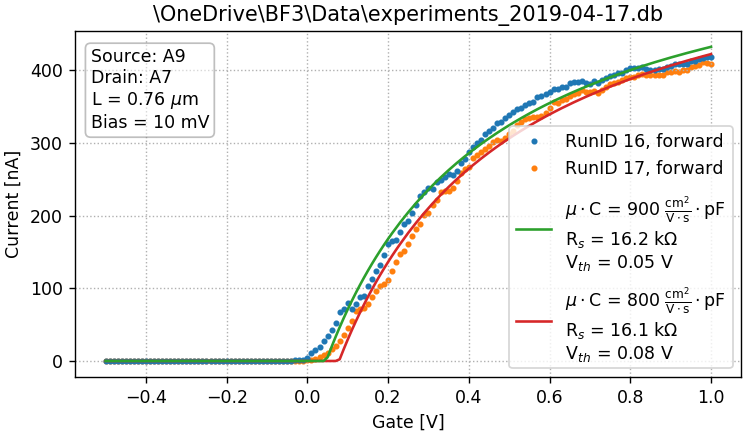

C:\Anaconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:248: RuntimeWarning: divide by zero encountered in true_divide


data format = [forward, backward]
mu*C = [900, 800] (cm^2 / (V*s)) * pF
Rs = [16.2, 16.1] kOhm
Vth = [0.047, 0.078] V
delta Vth = 31 mV
delta t between gate sweeps = 546 s
[forward, delay, backward] times: [105, 441, 100] s



In [19]:
IDs = [16, 17]
biases = np.array([10,10])*1e-3 # V
L = 0.76e-6 # m

I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L, reverse_g=True)

## Run IDs 22-23, FEM1, pinchoffs

<IPython.core.display.Javascript object>


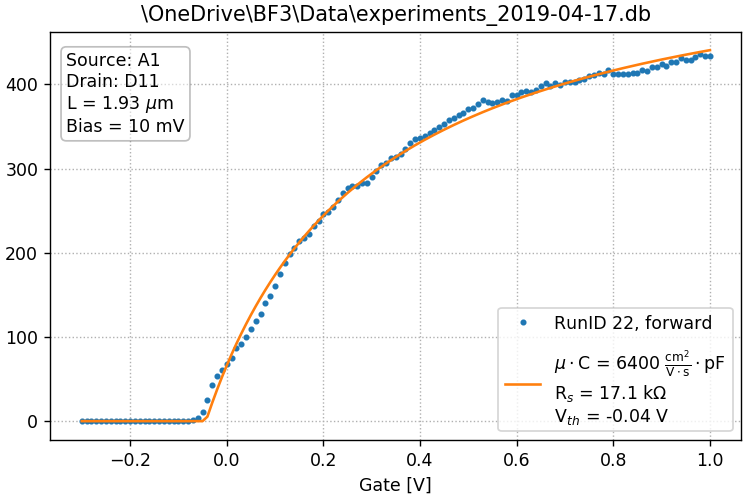

C:\Anaconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide


mu*C = 6400 (cm^2 / (V*s)) * pF
Rs = 17.1 kOhm
Vth = -0.043 V


In [32]:
ID = 22
bias = 10*1e-3 # V
L = 1.93e-6 # m

dat = load_by_id(ID)
dat.get_parameters()
gate = dat.get_data('mdac_CUT_voltage')
current1 = dat.get_data('current1')
current2 = dat.get_data('current2')
I_feel_good = plot_single_pinchoff(ID, gate, current1, bias, where_I_save_plots, L=L, reverse_g=True)
#I_feel_good = plot_single_pinchoff(ID, gate, current2, bias, where_I_save_plots, L=L, reverse_g=True)

# 2019-04-18.db

In [338]:
experiment_date = '2019-04-18'

qc.config["core"]["db_location"] = path(where_db_files_are, experiment_date)

initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists

## Run IDs 32,54,68 contact resistance from TLM1

<IPython.core.display.Javascript object>


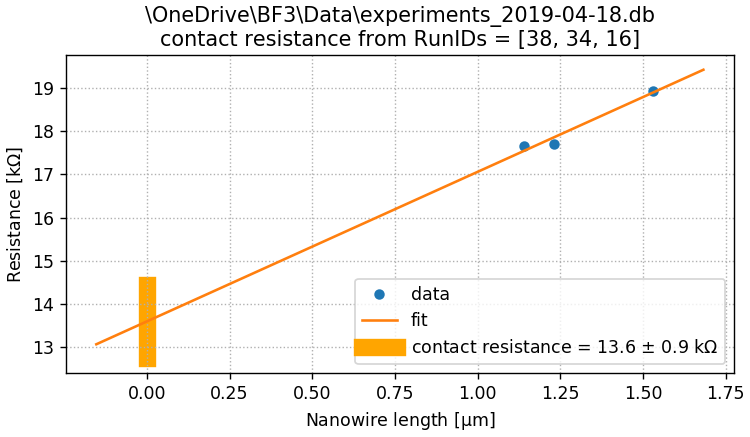

(13599.564719746575, 853.1278728697412)

In [339]:
IDs = [38, 34, 16]
#IDs = [39, 35, 17]
Ls = np.array([1.14, 1.23, 1.53])*1e-6
Vbias = 10e-3

TLM_contact_resistance(IDs, Ls, Vbias, interval=[1.8,2], current_name='current1')

<IPython.core.display.Javascript object>


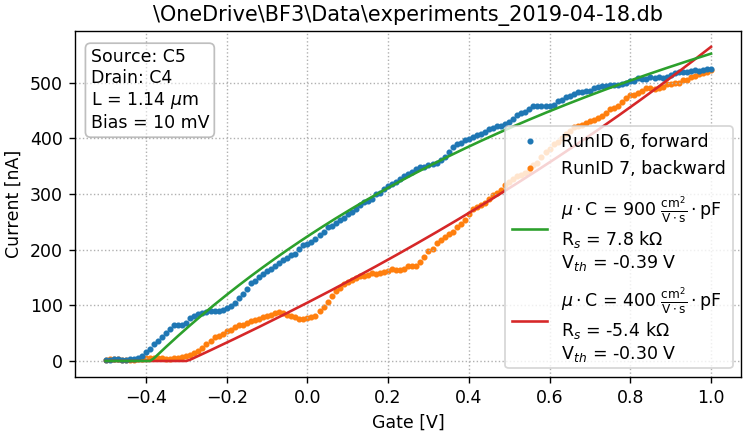

C:\Anaconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:251: RuntimeWarning: divide by zero encountered in true_divide


data format = [forward, backward]
mu*C = [900, 400] (cm^2 / (V*s)) * pF
Rs = [7.8, -5.4] kOhm
Vth = [-0.387, -0.297] V
delta Vth = 89 mV
delta t between gate sweeps = 92 s
[forward, delay, backward] times: [79, 13, 89] s



In [334]:
IDs = [6,7]
biases = np.array([10,10])*1e-3 # V
L = 1.14e-6 # m

dat = load_by_id(ID)
dat.get_parameters()
gate = dat.get_data('mdac_PG_voltage')
current = dat.get_data('current1')
g = dat.get_data('conductance1')

I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L, reverse_g=True, current_name='current1')

<IPython.core.display.Javascript object>


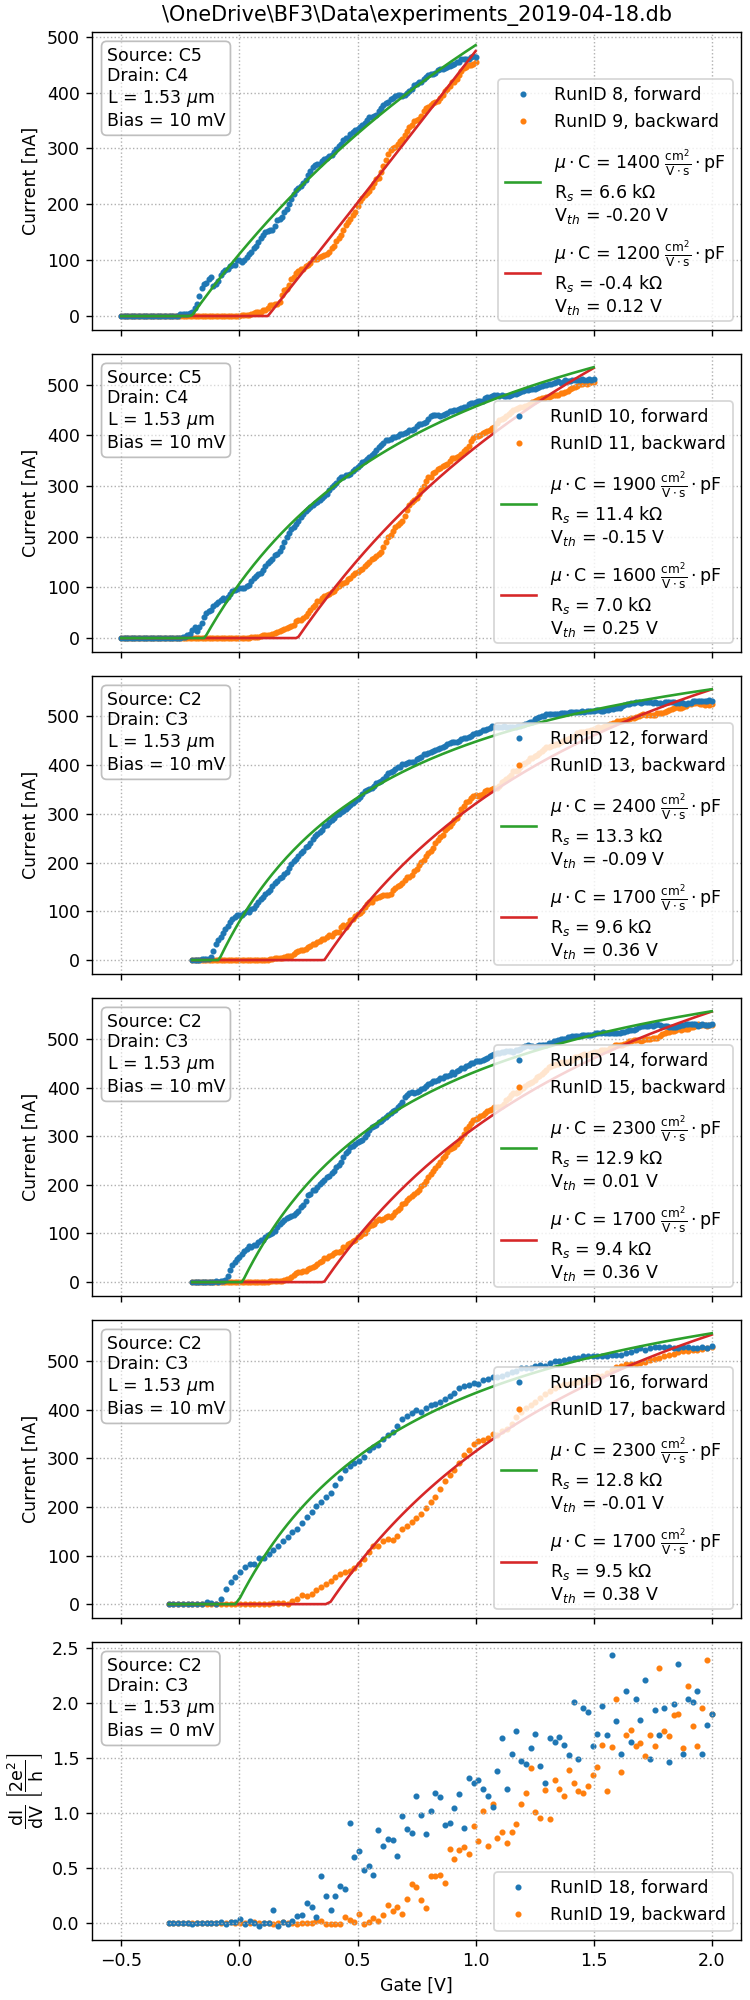

C:\Anaconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:250: RuntimeWarning: divide by zero encountered in true_divide


data format = [forward, backward]
mu*C = [1400, 1200] (cm^2 / (V*s)) * pF
Rs = [6.6, -0.4] kOhm
Vth = [-0.203, 0.12] V
delta Vth = 323 mV
delta t between gate sweeps = 90 s
[forward, delay, backward] times: [76, 13, 87] s

data format = [forward, backward]
mu*C = [1900, 1600] (cm^2 / (V*s)) * pF
Rs = [11.4, 7.0] kOhm
Vth = [-0.147, 0.246] V
delta Vth = 393 mV
delta t between gate sweeps = 116 s
[forward, delay, backward] times: [102, 13, 114] s

data format = [forward, backward]
mu*C = [2400, 1700] (cm^2 / (V*s)) * pF
Rs = [13.3, 9.6] kOhm
Vth = [-0.087, 0.359] V
delta Vth = 446 mV
delta t between gate sweeps = 122 s
[forward, delay, backward] times: [109, 13, 112] s

data format = [forward, backward]
mu*C = [2300, 1700] (cm^2 / (V*s)) * pF
Rs = [12.9, 9.4] kOhm
Vth = [0.012, 0.358] V
delta Vth = 346 mV
delta t between gate sweeps = 124 s
[forward, delay, backward] times: [110, 13, 113] s

data format = [forward, backward]
mu*C = [2300, 1700] (cm^2 / (V*s)) * pF
Rs = [12.8, 9.5] kOhm
V

In [46]:
IDs = [8,9,10,11,12,13,14,15,16,17,18,19]
biases = np.array([10,10,10,10,10,10,10,10,10,10,0,0])*1e-3 # V
L = 1.53e-6 # m

I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L, reverse_g=True, current_name='current1', g_name='conductance1')

<IPython.core.display.Javascript object>


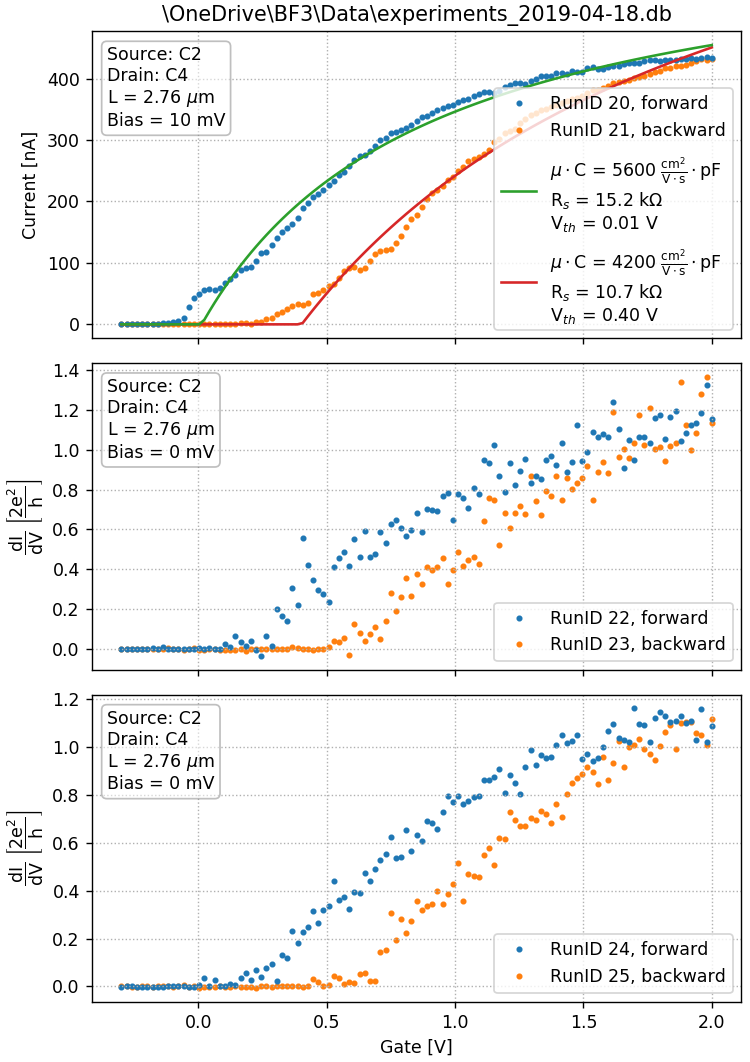

data format = [forward, backward]
mu*C = [5600, 4200] (cm^2 / (V*s)) * pF
Rs = [15.2, 10.7] kOhm
Vth = [0.013, 0.402] V
delta Vth = 389 mV
delta t between gate sweeps = 103 s
[forward, delay, backward] times: [89, 13, 93] s



In [47]:
IDs = [20,21,22,23,24,25]
biases = np.array([10,10,0,0,0,0])*1e-3 # V
L = (1.53 + 1.23)*1e-6 # m

I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L, reverse_g=True, current_name='current1', g_name='conductance1')

<IPython.core.display.Javascript object>


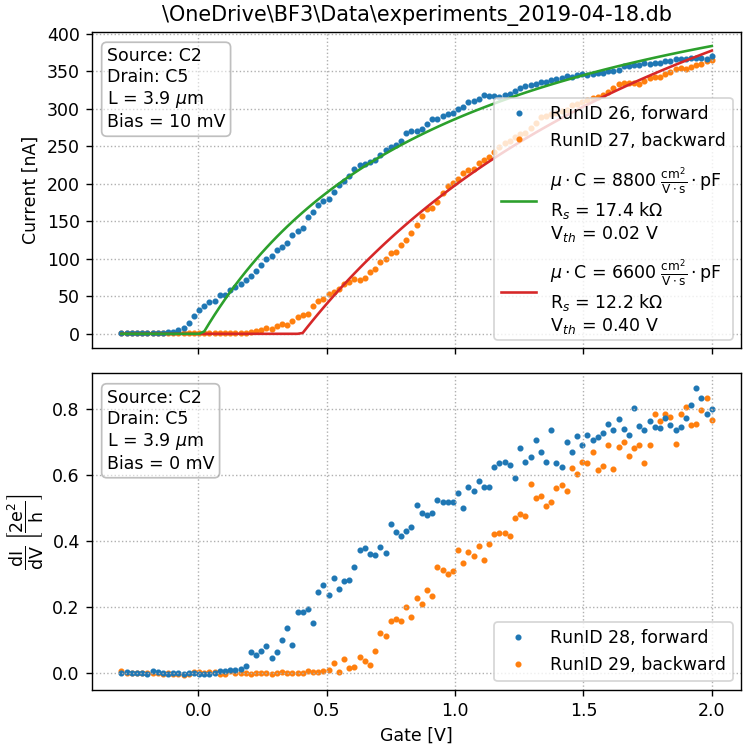

data format = [forward, backward]
mu*C = [8800, 6600] (cm^2 / (V*s)) * pF
Rs = [17.4, 12.2] kOhm
Vth = [0.017, 0.404] V
delta Vth = 386 mV
delta t between gate sweeps = 97 s
[forward, delay, backward] times: [84, 13, 93] s



In [48]:
IDs = [26,27,28,29]
biases = np.array([10,10,0,0])*1e-3 # V
L = (1.53 + 1.23 + 1.14)*1e-6 # m

I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L, reverse_g=True, current_name='current1', g_name='conductance1')

<IPython.core.display.Javascript object>


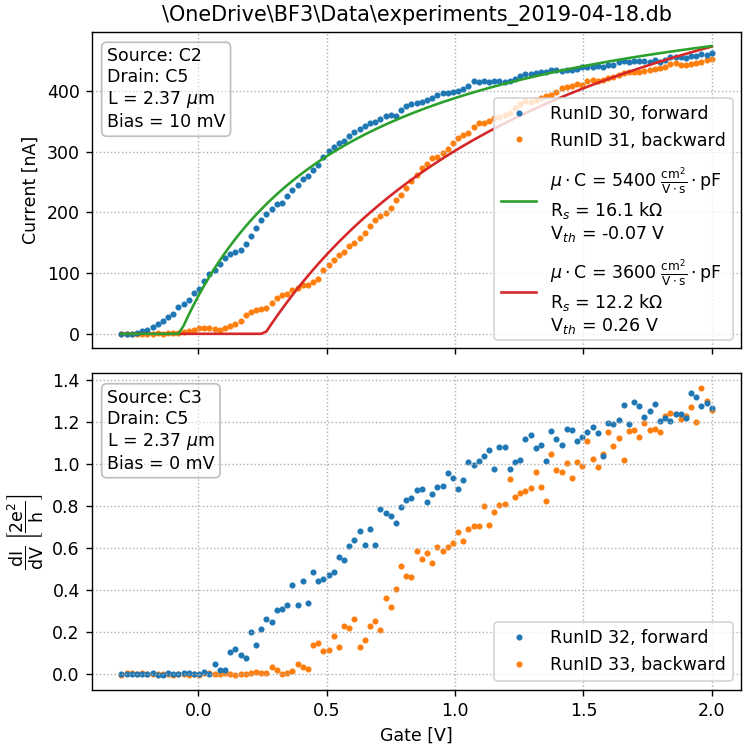

data format = [forward, backward]
mu*C = [5400, 3600] (cm^2 / (V*s)) * pF
Rs = [16.1, 12.2] kOhm
Vth = [-0.072, 0.259] V
delta Vth = 330 mV
delta t between gate sweeps = 103 s
[forward, delay, backward] times: [90, 13, 96] s



In [49]:
IDs = [30,31,32,33]
biases = np.array([10,10,0,0])*1e-3 # V
L = (1.23 + 1.14)*1e-6 # m

I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L, reverse_g=True, current_name='current1', g_name='conductance1')

<IPython.core.display.Javascript object>


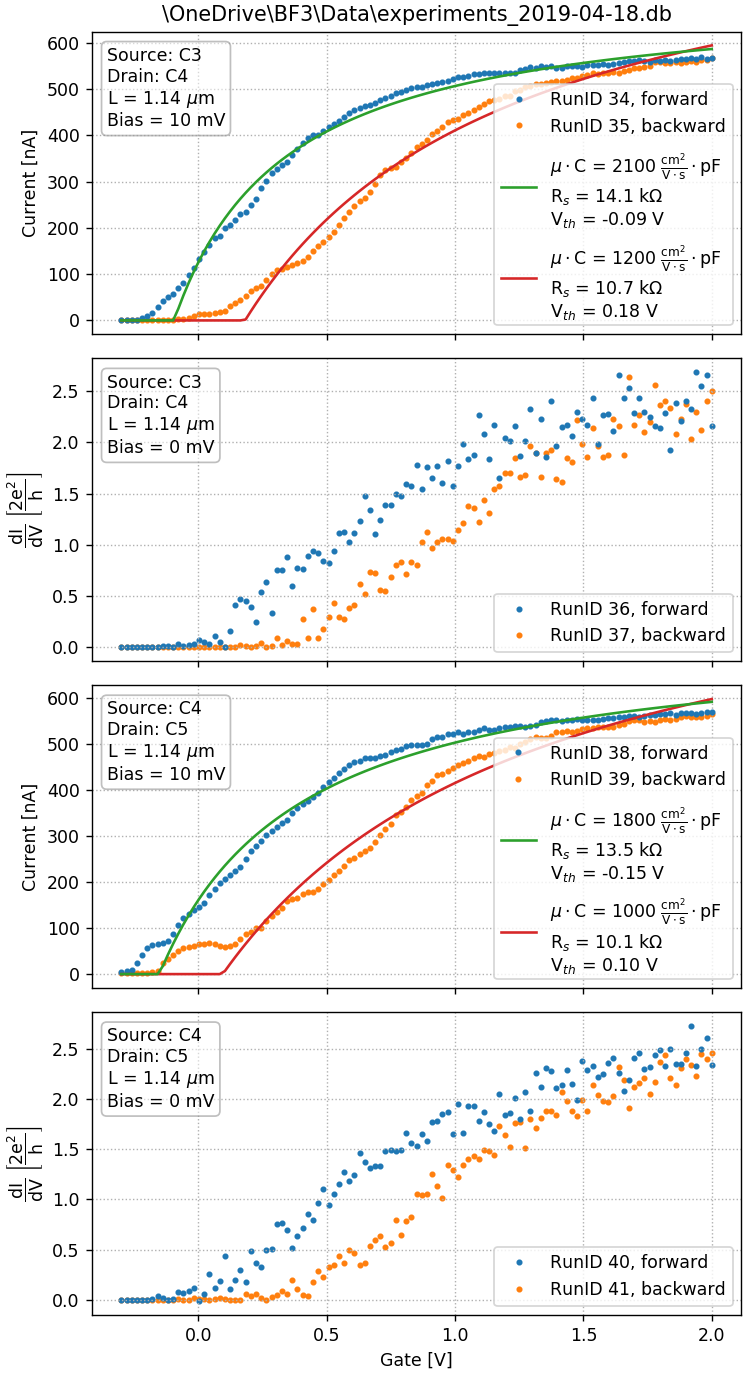

data format = [forward, backward]
mu*C = [2100, 1200] (cm^2 / (V*s)) * pF
Rs = [14.1, 10.7] kOhm
Vth = [-0.094, 0.182] V
delta Vth = 276 mV
delta t between gate sweeps = 102 s
[forward, delay, backward] times: [89, 13, 97] s

data format = [forward, backward]
mu*C = [1800, 1000] (cm^2 / (V*s)) * pF
Rs = [13.5, 10.1] kOhm
Vth = [-0.152, 0.095] V
delta Vth = 246 mV
delta t between gate sweeps = 103 s
[forward, delay, backward] times: [89, 13, 96] s



In [50]:
IDs = [34,35,36,37,38,39,40,41]
biases = np.array([10,10,0,0,10,10,0,0])*1e-3 # V
L = (1.14)*1e-6 # m

I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L, reverse_g=True, current_name='current1', g_name='conductance1')

# 2019-04-19.db

In [52]:
experiment_date = '2019-04-19'

qc.config["core"]["db_location"] = path(where_db_files_are, experiment_date)

initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists

## RunID 9, HB2, 2D field-gate sweep

In [56]:
RunID = 9

dat = load_by_id(RunID)
dat.get_parameters()
Bx = dat.get_data('AMI430_x_field')
PG = dat.get_data('mdac_PG_voltage')
gxx1 = dat.get_data('g_xx_1')
gxx2 = dat.get_data('g_xx_2')
Rxx1 = dat.get_data('R_xx_1')
Rxx2 = dat.get_data('R_xx_2')
Rxyj1 = dat.get_data('R_xy_j1')
Rxyj2 = dat.get_data('R_xy_j2')
phase1 = dat.get_data('Lockin1_phase')
phase2 = dat.get_data('Lockin2_phase')

<IPython.core.display.Javascript object>


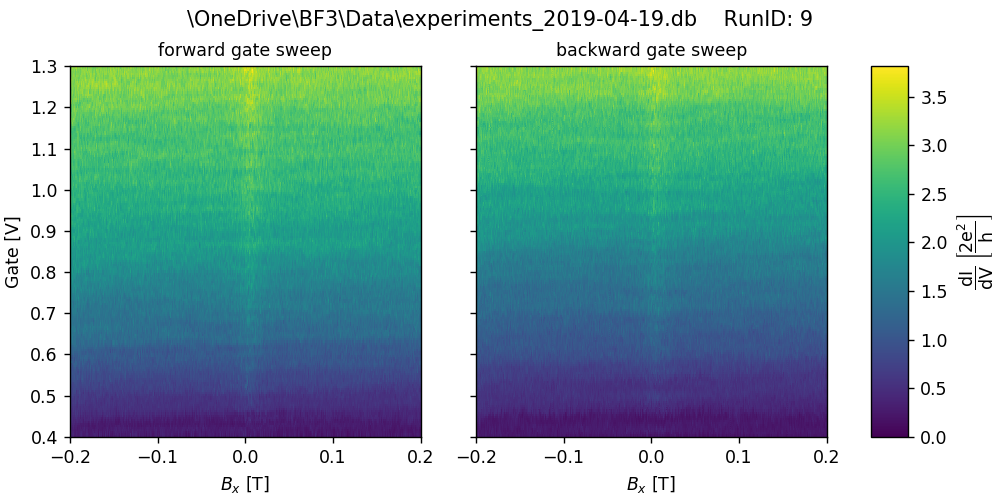

In [69]:
Bx_, PG_forth, PG_back, gxx2_forth, gxx2_back = unpack_back_and_forth(Bx, PG, gxx2)

fig, ax = colorplot_ForwardBackward(Bx_, PG_forth, (gxx2_forth, gxx2_back))
plt.suptitle(pretty_path(experiment_date) + '    RunID: ' + str(RunID), size='large')
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID) + '_g2'
plt.savefig(where, dpi=300)

<IPython.core.display.Javascript object>


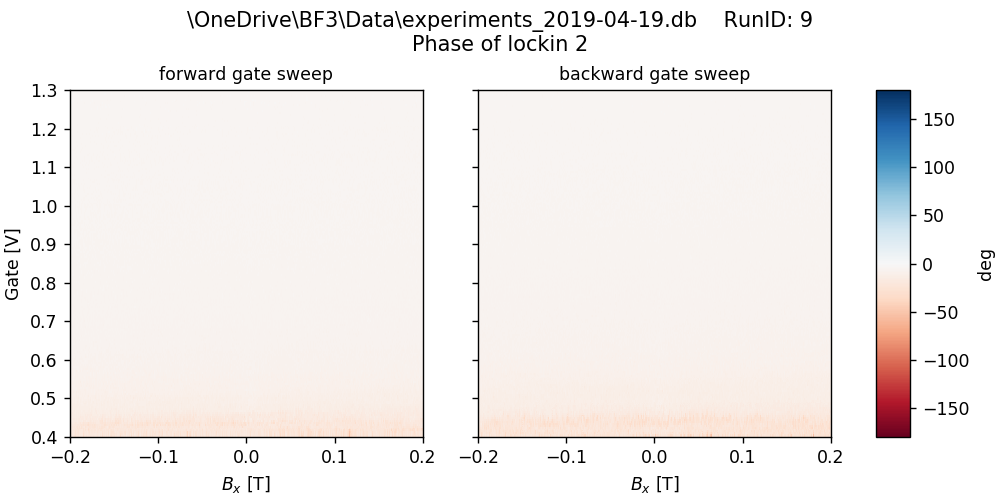

In [70]:
Bx_, PG_forth, PG_back, phase2_forth, phase2_back = unpack_back_and_forth(Bx, PG, phase2)

fig, ax = colorplot_phase_ForwardBackward(Bx_, PG_forth, (phase1_forth, phase1_back), degrange=180)
plt.suptitle(pretty_path(experiment_date) + '    RunID: ' + str(RunID) + '\nPhase of lockin 2', size='large')
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID) + 'phase2'
plt.savefig(where, dpi=300)

<IPython.core.display.Javascript object>


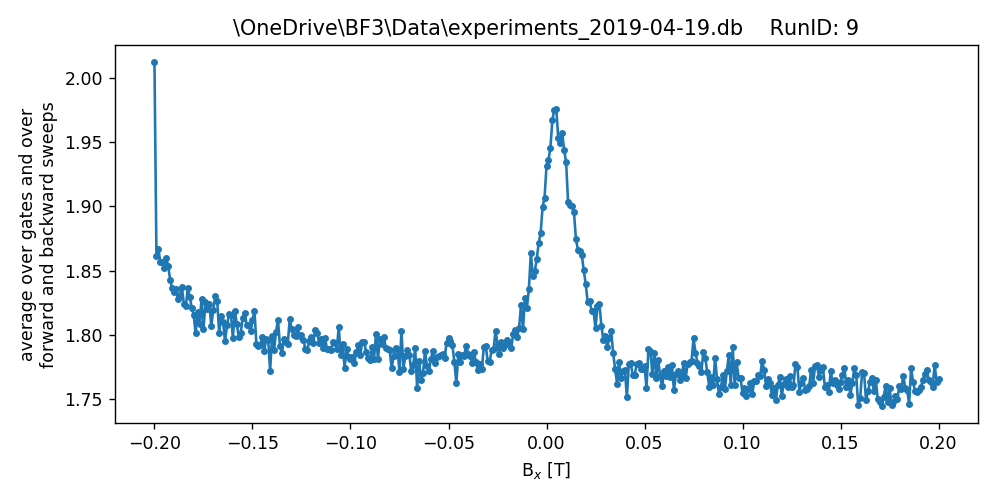

In [73]:
plt.figure('new_average').set_tight_layout(True)
a = brute_meaningless_gate_average(Bx_, PG_forth, gxx2_forth, cut=0.4)
b = brute_meaningless_gate_average(Bx_, PG_forth[::-1], gxx2_back, cut=0.4)
c = (a + b) / 2
#plt.plot(Bx_, a, '.-')
#plt.plot(Bx_, b, '.-')
plt.plot(Bx_, c, '.-')
plt.xlabel('B$_x$ [T]')
plt.ylabel('average over gates and over\nforward and backward sweeps')
plt.title(pretty_path(experiment_date) + '    RunID: ' + str(RunID), size='large')
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID) + '_brute_meaningless_average_2'
plt.savefig(where, dpi=300)

<IPython.core.display.Javascript object>


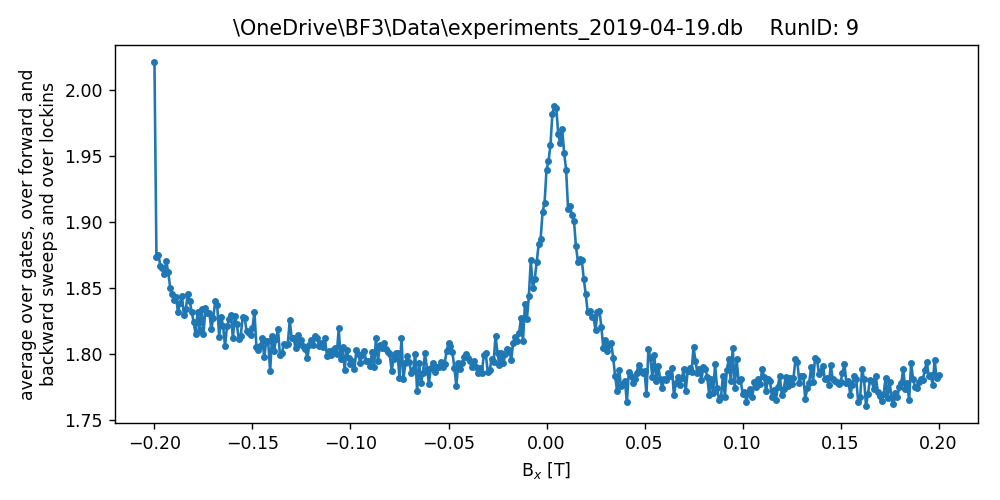

In [78]:
plt.figure('new_big_average').set_tight_layout(True)
a1 = brute_meaningless_gate_average(Bx_, PG_forth, gxx1_forth, cut=0.4)
b1 = brute_meaningless_gate_average(Bx_, PG_forth[::-1], gxx1_back, cut=0.4)
c1 = (a1 + b1) / 2
a2 = brute_meaningless_gate_average(Bx_, PG_forth, gxx2_forth, cut=0.4)
b2 = brute_meaningless_gate_average(Bx_, PG_forth[::-1], gxx2_back, cut=0.4)
c2 = (a2 + b2) / 2
d = (c1 + c2) / 2
#plt.plot(Bx_, c1, '.-')
#plt.plot(Bx_, c2, '.-')
plt.plot(Bx_, d, '.-')
plt.xlabel('B$_x$ [T]')
plt.ylabel('average over gates, over forward and\nbackward sweeps and over lockins')
plt.title(pretty_path(experiment_date) + '    RunID: ' + str(RunID), size='large')
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID) + '_brute_meaningless_big_average'
plt.savefig(where, dpi=300)

### Hall bar mobility

In [79]:
w = 190e-9 # A
Lxx = 1.99e-6 # m

<IPython.core.display.Javascript object>


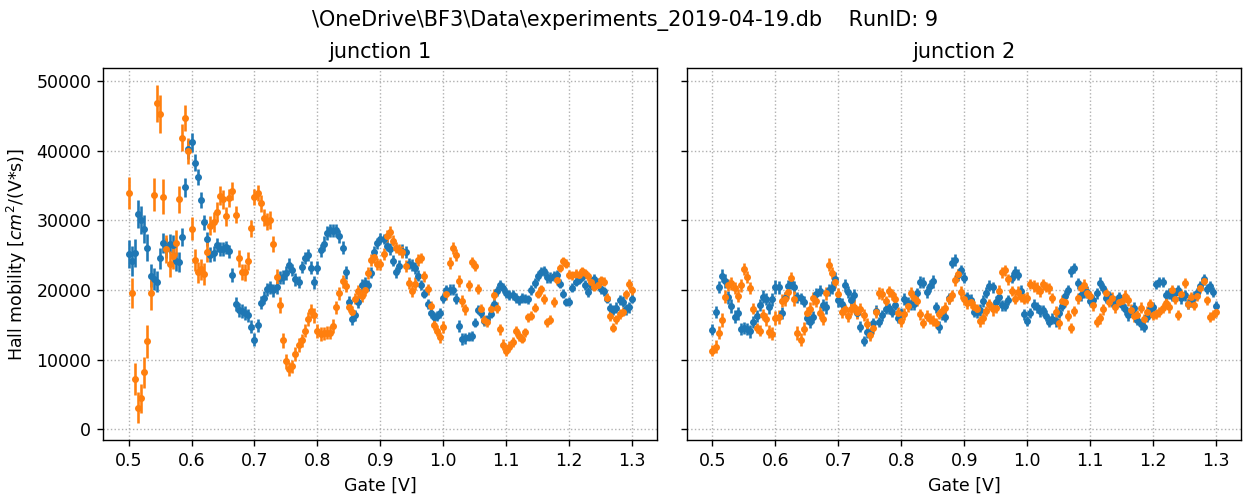

In [83]:
Bx_, PG_forth, PG_back, Rxx1_forth, Rxx1_back = unpack_back_and_forth(Bx, PG, Rxx1)
_, __, ___, Rxyj1_forth, Rxyj1_back = unpack_back_and_forth(Bx, PG, Rxyj1)
_, __, ___, Rxyj2_forth, Rxyj2_back = unpack_back_and_forth(Bx, PG, Rxyj2)

mus_forth, dmus_forth = hall_bar_mobilities(Bx_, Rxx1_forth, Rxyj1_forth, Lxx, w)
mus_back, dmus_back = hall_bar_mobilities(Bx_, Rxx1_back, Rxyj1_back, Lxx, w)

params = {'legend.fontsize': 'medium',
              'figure.figsize': (10, 4),
              'axes.labelsize': 'medium',
              'axes.titlesize':'large',
              'xtick.labelsize':'medium',
              'ytick.labelsize':'medium'}
mpl.rcParams.update(params)
fig, axes = plt.subplots(ncols=2, nrows=1, sharey=True, constrained_layout=True)
plt.suptitle(pretty_path(experiment_date) + '    RunID: ' + str(RunID), size='large')
axes[0].set(ylabel='Hall mobility [$cm^2$/(V*s)]')
Rxy_forths = (Rxyj1_forth, Rxyj2_forth)
Rxy_backs = (Rxyj1_back, Rxyj2_back)
for i, ax in enumerate(axes):
    mus_forth, dmus_forth = hall_bar_mobilities(Bx_, Rxx1_forth, Rxy_forths[i], Lxx, w)
    mus_back, dmus_back = hall_bar_mobilities(Bx_, Rxx1_back, Rxy_backs[i], Lxx, w)
    cut = 0.5
    ax.errorbar(PG_forth[PG_forth>=cut], mus_forth[PG_forth>=cut]*1e4, fmt='.', yerr=dmus_forth[PG_forth>=cut]*1e4)
    ax.errorbar(PG_back[PG_back>=cut], mus_back[PG_back>=cut]*1e4, fmt='.', yerr=dmus_back[PG_back>=cut]*1e4)
    ax.set(xlabel='Gate [V]', title='junction {}'.format(i+1))
    ax.grid(linestyle=':')
where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID) + '_hall_mobility'
plt.savefig(where, dpi=300)

<IPython.core.display.Javascript object>


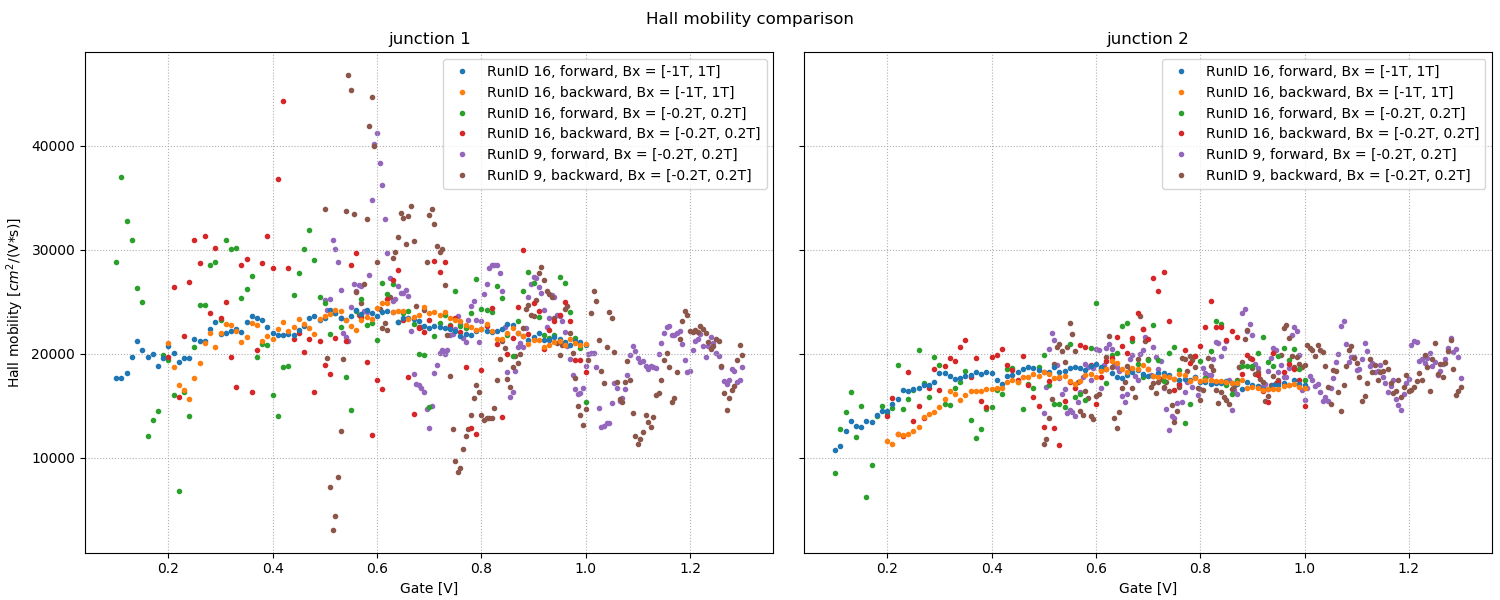

In [26]:
experiment_date = '2019-04-10'
qc.config["core"]["db_location"] = path(where_db_files_are, experiment_date)
initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists

RunID = 16
dat = load_by_id(RunID)
Bx = dat.get_data('AMI430_x_field')
PG = dat.get_data('mdac_PG_voltage')
Rxx = np.array(dat.get_values('R_xx'))
Rxyj1 = np.array(dat.get_values('R_xy_j1'))
Rxyj2 = np.array(dat.get_values('R_xy_j2'))

Bx_, PG_forth, PG_back, Rxx_forth, Rxx_back = unpack_back_and_forth(Bx, PG, Rxx)
_, __, ___, Rxyj1_forth, Rxyj1_back = unpack_back_and_forth(Bx, PG, Rxyj1)
_, __, ___, Rxyj2_forth, Rxyj2_back = unpack_back_and_forth(Bx, PG, Rxyj2)

params = {'legend.fontsize': 'medium',
              'figure.figsize': (15, 6),
              'axes.labelsize': 'medium',
              'axes.titlesize':'large',
              'xtick.labelsize':'medium',
              'ytick.labelsize':'medium'}
mpl.rcParams.update(params)

fig, axes = plt.subplots(ncols=2, nrows=1, sharey=True, constrained_layout=True, num='Hall mobility comparison')
plt.suptitle('Hall mobility comparison', size='large')
axes[0].set(ylabel='Hall mobility [$cm^2$/(V*s)]')
Rxy_forths = (Rxyj1_forth, Rxyj2_forth)
Rxy_backs = (Rxyj1_back, Rxyj2_back)

for i, ax in enumerate(axes):
    mus_forth, dmus_forth = hall_bar_mobilities(Bx_, Rxx_forth, Rxy_forths[i], Lxx, w)
    mus_back, dmus_back = hall_bar_mobilities(Bx_, Rxx_back, Rxy_backs[i], Lxx, w)
    label = 'RunID ' + str(RunID) + ', forward, Bx = [-1T, 1T]'
    ax.plot(PG_forth[PG_forth>=0.1], mus_forth[PG_forth>=0.1]*1e4, '.', zorder=5, label=label)
    label = 'RunID ' + str(RunID) + ', backward, Bx = [-1T, 1T]'
    ax.plot(PG_back[PG_back>=0.2], mus_back[PG_back>=0.2]*1e4, '.', zorder=6, label=label)

for i, ax in enumerate(axes):
    Bx_temp = Bx_
    Bx_cutted = Bx_temp[np.logical_and(Bx_>=-0.2, Bx_<=0.2)]
    Rxx_forth_cutted = Rxx_forth[np.logical_and(Bx_>=-0.2, Bx_<=0.2)]
    Rxy_forth_cutted = Rxy_forths[i][np.logical_and(Bx_>=-0.2, Bx_<=0.2)]
    Rxx_back_cutted = Rxx_back[np.logical_and(Bx_>=-0.2, Bx_<=0.2)]
    Rxy_back_cutted = Rxy_backs[i][np.logical_and(Bx_>=-0.2, Bx_<=0.2)]
    mus_forth, dmus_forth = hall_bar_mobilities(Bx_cutted, Rxx_forth_cutted, Rxy_forth_cutted, Lxx, w)
    mus_back, dmus_back = hall_bar_mobilities(Bx_cutted, Rxx_back_cutted, Rxy_back_cutted, Lxx, w)
    label = 'RunID ' + str(RunID) + ', forward, Bx = [-0.2T, 0.2T]'
    ax.plot(PG_forth[PG_forth>=0.1], mus_forth[PG_forth>=0.1]*1e4, '.', zorder=3, label=label)
    label = 'RunID ' + str(RunID) + ', backward, Bx = [-0.2T, 0.2T]'
    ax.plot(PG_back[PG_back>=0.2], mus_back[PG_back>=0.2]*1e4, '.', zorder=4, label=label)

experiment_date = '2019-04-19'
qc.config["core"]["db_location"] = path(where_db_files_are, experiment_date)
initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists
    
RunID = 9
dat = load_by_id(RunID)
dat.get_parameters()
Bx = dat.get_data('AMI430_x_field')
PG = dat.get_data('mdac_PG_voltage')
Rxx1 = dat.get_data('R_xx_1')
Rxx2 = dat.get_data('R_xx_2')
Rxyj1 = dat.get_data('R_xy_j1')
Rxyj2 = dat.get_data('R_xy_j2')   
    
Bx_, PG_forth, PG_back, Rxx1_forth, Rxx1_back = unpack_back_and_forth(Bx, PG, Rxx1)
_, __, ___, Rxyj1_forth, Rxyj1_back = unpack_back_and_forth(Bx, PG, Rxyj1)
_, __, ___, Rxyj2_forth, Rxyj2_back = unpack_back_and_forth(Bx, PG, Rxyj2)

mus_forth, dmus_forth = hall_bar_mobilities(Bx_, Rxx1_forth, Rxyj1_forth, Lxx, w)
mus_back, dmus_back = hall_bar_mobilities(Bx_, Rxx1_back, Rxyj1_back, Lxx, w)

Rxy_forths = (Rxyj1_forth, Rxyj2_forth)
Rxy_backs = (Rxyj1_back, Rxyj2_back)
for i, ax in enumerate(axes):
    mus_forth, dmus_forth = hall_bar_mobilities(Bx_, Rxx1_forth, Rxy_forths[i], Lxx, w)
    mus_back, dmus_back = hall_bar_mobilities(Bx_, Rxx1_back, Rxy_backs[i], Lxx, w)
    cut = 0.5
    label = 'RunID ' + str(RunID) + ', forward, Bx = [-0.2T, 0.2T]'
    ax.plot(PG_forth[PG_forth>=cut], mus_forth[PG_forth>=cut]*1e4, '.', zorder=1, label=label)
    label = 'RunID ' + str(RunID) + ', backward, Bx = [-0.2T, 0.2T]'
    ax.plot(PG_back[PG_back>=cut], mus_back[PG_back>=cut]*1e4, '.', zorder=2, label=label)
    ax.set(xlabel='Gate [V]', title='junction {}'.format(i+1))
    ax.grid(linestyle=':')
    ax.legend()

where = 'Albertos_plots/' + experiment_date + '_RunID' + str(RunID) + '_hall_mobility_comparison'
plt.savefig(where, dpi=300)

# 2019-04-22.db

In [85]:
experiment_date = '2019-04-22'

qc.config["core"]["db_location"] = path(where_db_files_are, experiment_date)

initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists

## Run IDs 6-7, QPC2, pinchoffs

<IPython.core.display.Javascript object>


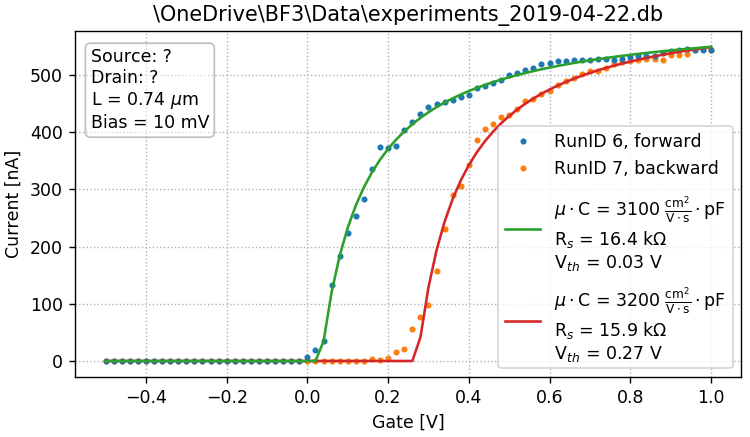

C:\Anaconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:250: RuntimeWarning: divide by zero encountered in true_divide


data format = [forward, backward]
mu*C = [3100, 3200] (cm^2 / (V*s)) * pF
Rs = [16.4, 15.9] kOhm
Vth = [0.034, 0.273] V
delta Vth = 238 mV
delta t between gate sweeps = 323 s
[forward, delay, backward] times: [322, 1, 406] s



In [86]:
IDs = [6,7]
biases = np.array([10,10])*1e-3 # V
L = 0.74*1e-6 # m

I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L, reverse_g=True, current_name='current1', g_name='conductance1')

# 2019-04-24.db

In [90]:
experiment_date = '2019-04-24'

qc.config["core"]["db_location"] = path(where_db_files_are, experiment_date)

initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists

## Run IDs 11-22, TLM2_B6B5

<IPython.core.display.Javascript object>


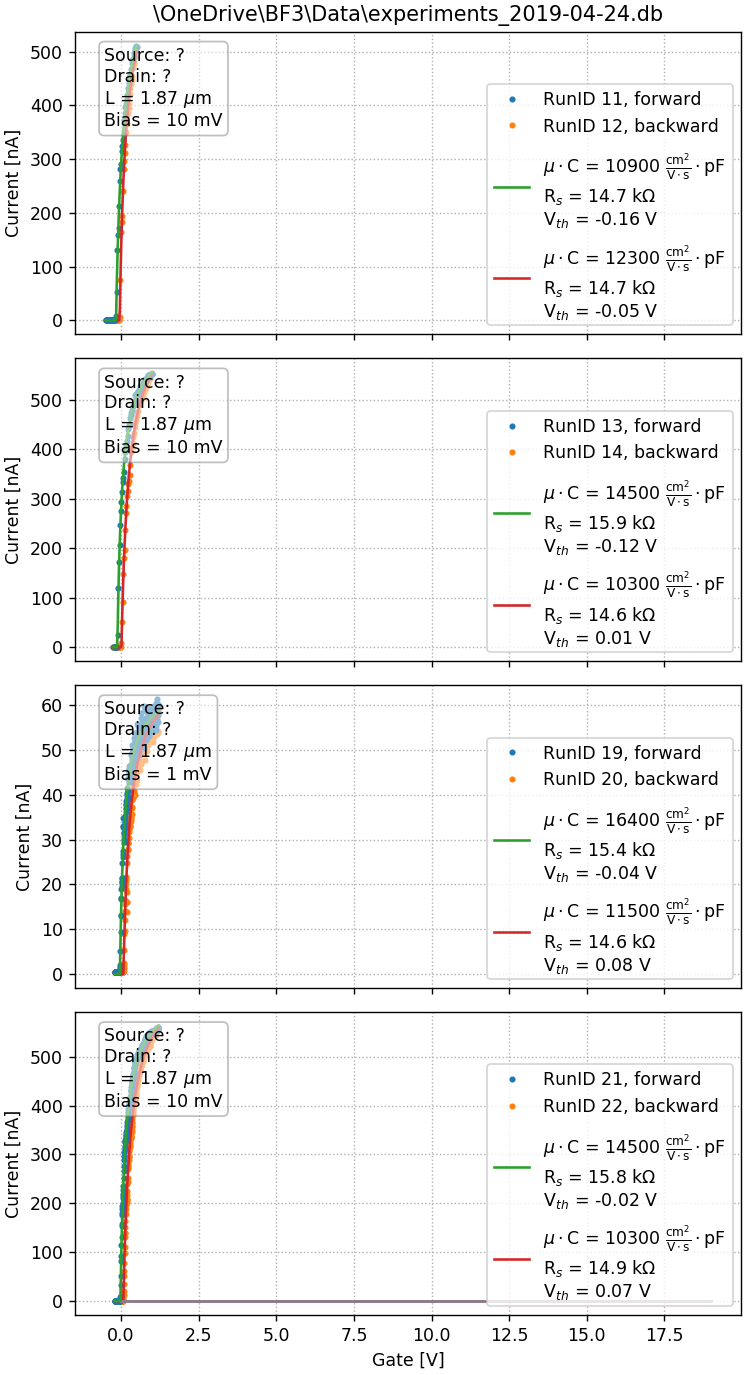

C:\Anaconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:250: RuntimeWarning: divide by zero encountered in true_divide


data format = [forward, backward]
mu*C = [10900, 12300] (cm^2 / (V*s)) * pF
Rs = [14.7, 14.7] kOhm
Vth = [-0.163, -0.046] V
delta Vth = 116 mV
delta t between gate sweeps = 642 s
[forward, delay, backward] times: [641, 1, 968] s

data format = [forward, backward]
mu*C = [14500, 10300] (cm^2 / (V*s)) * pF
Rs = [15.9, 14.6] kOhm
Vth = [-0.12, 0.011] V
delta Vth = 131 mV
delta t between gate sweeps = 780 s
[forward, delay, backward] times: [779, 1, 999] s

data format = [forward, backward]
mu*C = [16400, 11500] (cm^2 / (V*s)) * pF
Rs = [15.4, 14.6] kOhm
Vth = [-0.038, 0.076] V
delta Vth = 114 mV
delta t between gate sweeps = 976 s
[forward, delay, backward] times: [974, 1, 1103] s

data format = [forward, backward]
mu*C = [14500, 10300] (cm^2 / (V*s)) * pF
Rs = [15.8, 14.9] kOhm
Vth = [-0.022, 0.073] V
delta Vth = 94 mV
delta t between gate sweeps = 996 s
[forward, delay, backward] times: [995, 1, 1152] s



In [104]:
IDs = [11,12,13,14,19,20,21,22]
biases = np.array([10,10,10,10,1,1,10,10])*1e-3 # V
L = 1.87*1e-6 # m

datus = load_by_id(21)
datus.get_parameters()
I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L, reverse_g=True, gate_name='mdac_3GATES_voltage', current_name='current2', g_name='conductance2', tag='-TLM2_B6B5_vth')

## Run IDs 11-22, FEM3

<IPython.core.display.Javascript object>


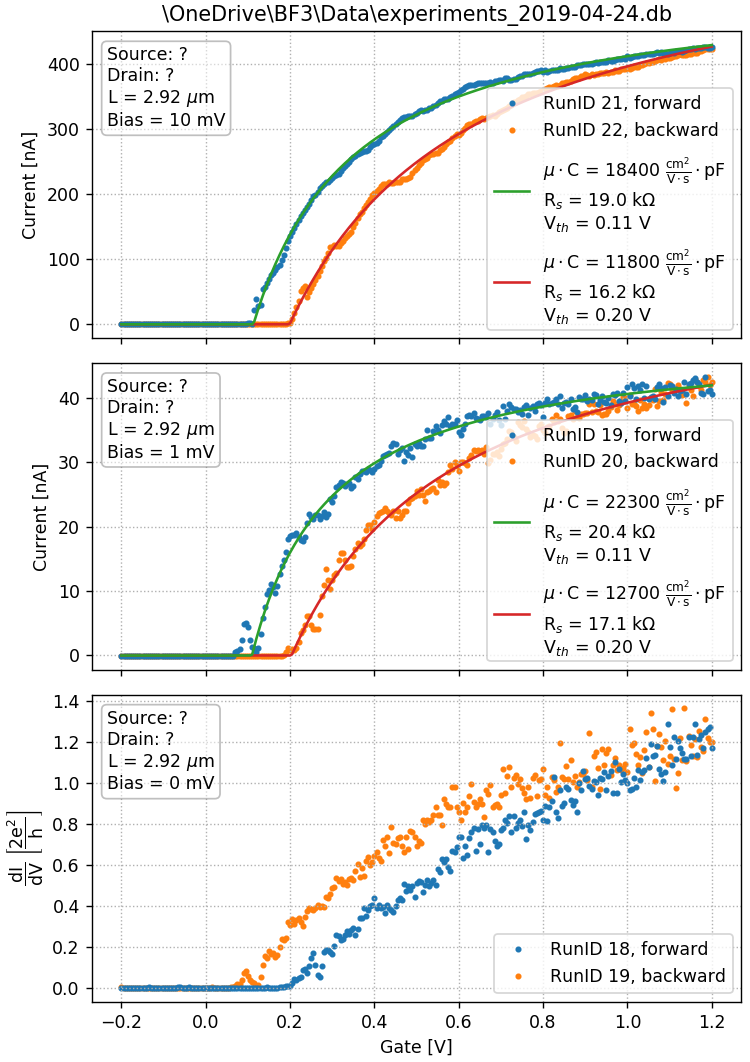

C:\Anaconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:250: RuntimeWarning: divide by zero encountered in true_divide


data format = [forward, backward]
mu*C = [18400, 11800] (cm^2 / (V*s)) * pF
Rs = [19.0, 16.2] kOhm
Vth = [0.113, 0.199] V
delta Vth = 85 mV
delta t between gate sweeps = 996 s
[forward, delay, backward] times: [995, 1, 1152] s

data format = [forward, backward]
mu*C = [22300, 12700] (cm^2 / (V*s)) * pF
Rs = [20.4, 17.1] kOhm
Vth = [0.109, 0.204] V
delta Vth = 94 mV
delta t between gate sweeps = 976 s
[forward, delay, backward] times: [974, 1, 1103] s



In [100]:
IDs = [21,22,19,20,18,19]
biases = np.array([10,10,1,1,0,0])*1e-3 # V
L = 2.92*1e-6 # m

datus = load_by_id(21)
datus.get_parameters()
I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L, reverse_g=True, gate_name='mdac_3GATES_voltage', current_name='current3', g_name='conductance3', tag='-FEM3')

## Run IDs 11-22, FEM1

<IPython.core.display.Javascript object>


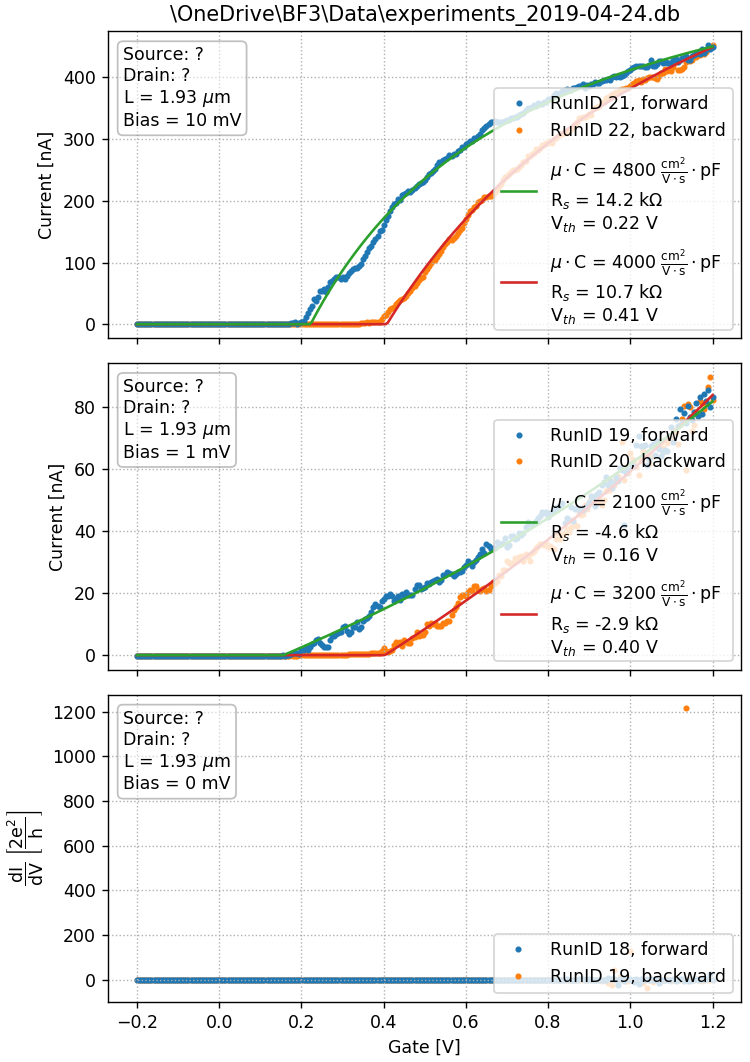

C:\Anaconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:250: RuntimeWarning: divide by zero encountered in true_divide


data format = [forward, backward]
mu*C = [4800, 4000] (cm^2 / (V*s)) * pF
Rs = [14.2, 10.7] kOhm
Vth = [0.222, 0.408] V
delta Vth = 185 mV
delta t between gate sweeps = 996 s
[forward, delay, backward] times: [995, 1, 1152] s

data format = [forward, backward]
mu*C = [2100, 3200] (cm^2 / (V*s)) * pF
Rs = [-4.6, -2.9] kOhm
Vth = [0.157, 0.403] V
delta Vth = 246 mV
delta t between gate sweeps = 976 s
[forward, delay, backward] times: [974, 1, 1103] s



In [101]:
IDs = [21,22,19,20,18,19]
biases = np.array([10,10,1,1,0,0])*1e-3 # V
L = 1.93*1e-6 # m

datus = load_by_id(21)
datus.get_parameters()
I_feel_good = plot_pinchoff(IDs, biases, where_I_save_plots, L=L, reverse_g=True, gate_name='mdac_3GATES_voltage', current_name='current4', g_name='conductance4', tag='-FEM1')

# Summary FEM plot

In [38]:
mucs = [7100, 6900, 4000, 6400, 6300, 
        19600, 11500, 22300, 12700, 18400, 11800,
       7100,
       8300, 7500, 8400, 8300, 6800, 9800, 7800,
       6900, 4700, 7600, 5600,
       12600, 10700, 12400, 13100, 16400, 11500, 14500, 10300,
       27700, 19300,
       6400, 5600,
       7200, 6300,
       15900, 12000,
       9600, 8800]

dirs = ['f', 'f', 'b', 'f', 'f',
       'f', 'b', 'f', 'b', 'f', 'b',
       'f',
       'f', 'b', 'f', 'f', 'b', 'f', 'b',
       'f', 'b', 'f', 'b',
       'f', 'b', 'f', 'b', 'f', 'b', 'f', 'b',
       'f', 'b',
       'f', 'b',
       'f', 'b',
       'f', 'b',
       'f', 'b']

lens = [1.93, 1.93, 1.93, 1.93, 1.93,
       2.92, 2.92, 2.92, 2.92, 2.92, 2.92,
       1.14,
       1.56, 1.56, 1.56, 1.56, 1.56, 1.56, 1.56,
       1.42, 1.42, 1.42, 1.42,
       1.87, 1.87, 1.87, 1.87, 1.87, 1.87, 1.87, 1.87,
       3.44, 3.44,
       1.39, 1.39,
       1.46, 1.46,
       3.63, 3.63,
       1.34, 1.34]

mucs = np.array(mucs)
dirs = np.array(dirs)
lens = np.array(lens)

caps = lens/2
mus = mucs/caps

<IPython.core.display.Javascript object>


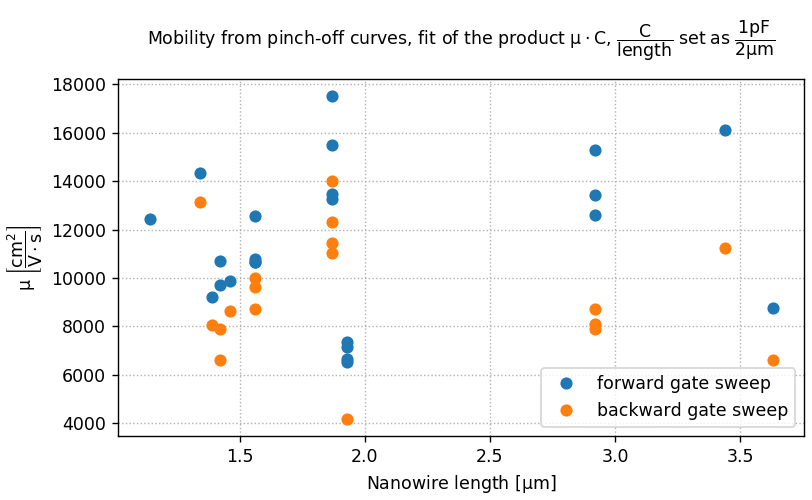

In [42]:
plt.figure('FE mobility', constrained_layout=True, figsize=(6.5,4))
plt.plot(lens[dirs=='f'], mus[dirs=='f'], 'o', label='forward gate sweep')
plt.plot(lens[dirs=='b'], mus[dirs=='b'], 'o', label='backward gate sweep')
plt.ylabel('$\\mathrm{{\\mu}}$ $\\left[\\mathrm{{\\dfrac{{cm^2}}{{V \cdot s}}}}\\right]$')
plt.xlabel('Nanowire length [$\\mathrm{{\mu}}$m]')
plt.title('Mobility from pinch-off curves, fit of the product $\\mathrm{{\\mu \cdot C}}$, $\\mathrm{{\\dfrac{{C}}{{length}} \\; set\\; as\\; \\dfrac{{1 pF}}{{2 \\mu m}}}}$\n', size='medium')
plt.legend()
plt.grid(linestyle=':', b=True)
where = 'Albertos_plots/' 'FE_mobility_summary'
plt.savefig(where, dpi=300)

In [1]:
import numpy as np